In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw

import os

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [2]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2), 
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
data_folder = "../../simulation/data/"
sim_folder = data_folder + "simulation/"

total_DCOs_in_MW = np.load("../../simulation/data/total_DCO_in_MW.npy")

detections = np.load("../../simulation/data/detections_4yr.npy")
detections_10yr = np.load("../../simulation/data/detections_10yr.npy")

## Floor's 5 main channels

In [3]:
channels = np.array([
    {
        "label": "Other",
        "colour": "#808080"
    },
    {
        "label": "Classic",
        "colour": "#118ab2"
    },
    {
        "label": "Only Stable",
        "colour": "#ef476f"
    },
    {
        "label": "Single Core CEE",
        "colour": "#ffd166"
    },
    {
        "label": "Double Core CEE",
        "colour": "#073b4c"
    },
])

resort_channels = [1, 2, 3, 4, 0]

<Figure size 864x576 with 0 Axes>

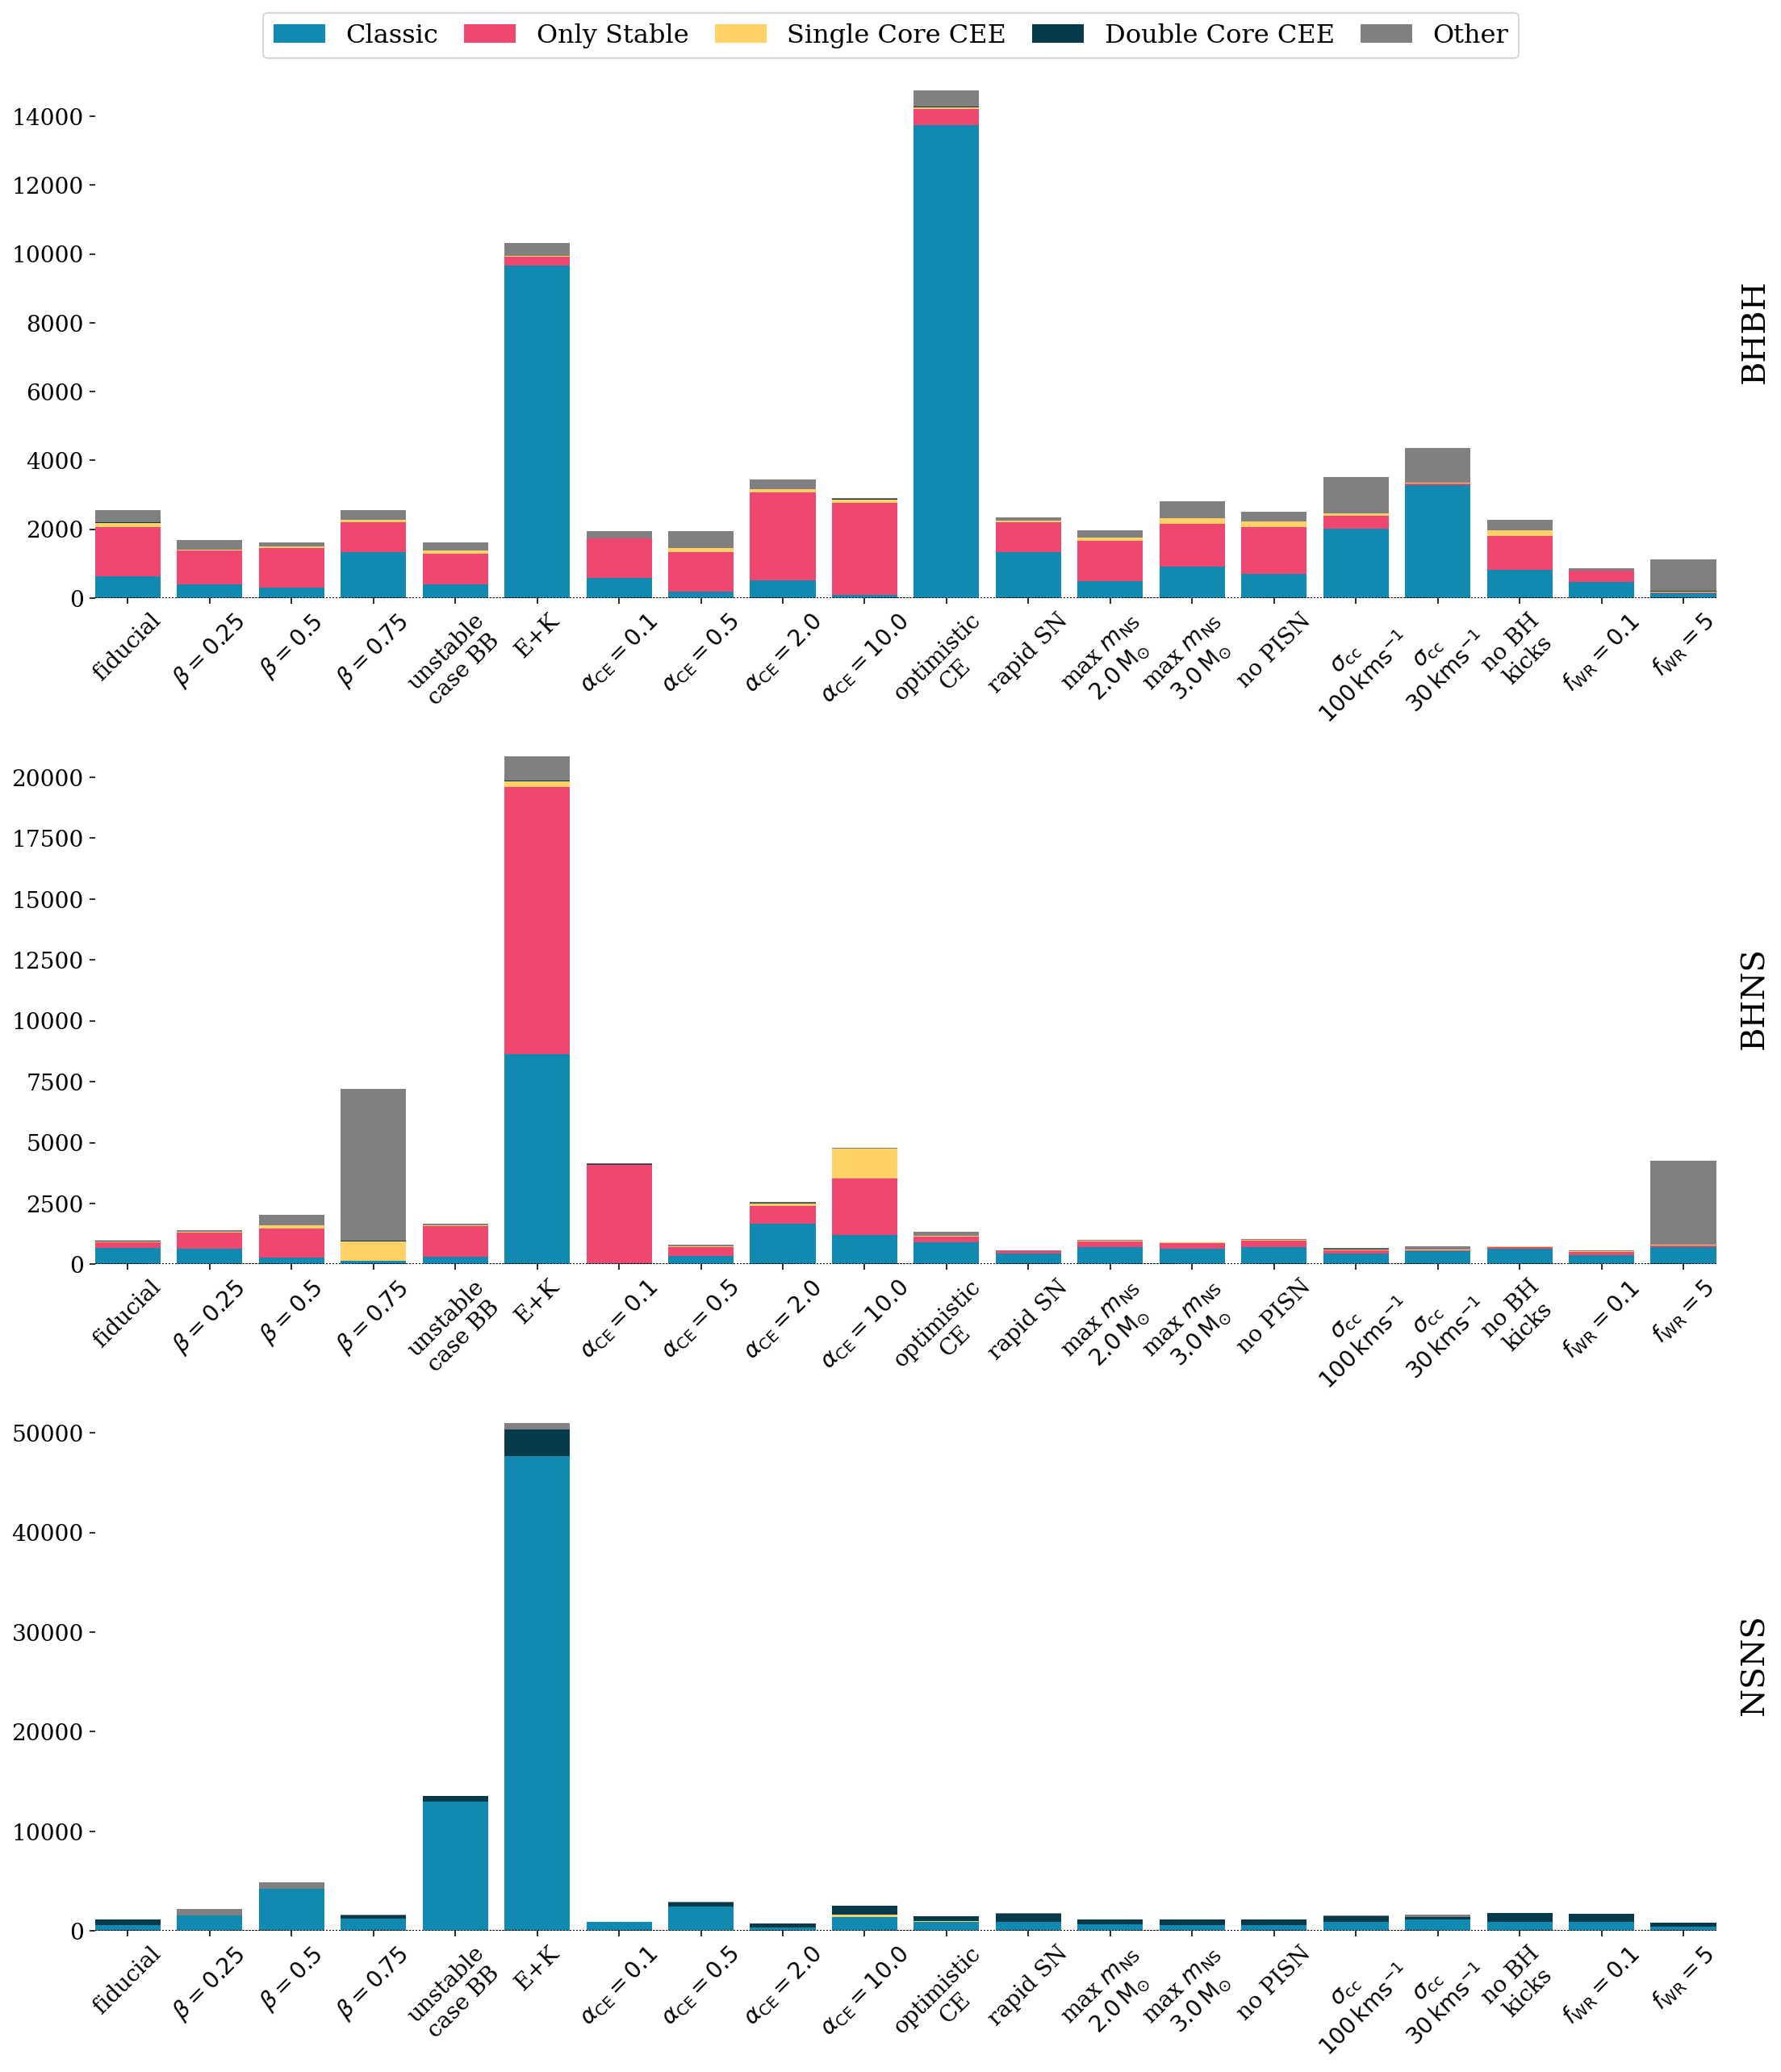

In [8]:
colours = np.array([channels[c]["colour"] for c in resort_channels])
labels = np.array([channels[c]["label"] for c in resort_channels])

fig, ax = plt.subplots()

ax.pie([0.2, 0.2, 0.2, 0.2, 0.2], colors=colours, labels=labels)
handles, leg_labels = ax.get_legend_handles_labels()

plt.clf()

fig, axes = plt.subplots(3, 1, figsize=(18, 19))
fig.subplots_adjust(top=0.97, hspace=0.25)

fig.legend(handles, labels, loc='upper center', fontsize=0.8*fs, ncol=5, columnspacing=1.0)

for i, dco_type in enumerate(dco_types):
    for v in range(len(variations)):
        if os.path.isfile(sim_folder + "{}_{}_all.h5".format(dco_type, variations[v]["file"])):
            with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[v]["file"]), "r") as f:
                full_data = f["simulation"][...].squeeze()
                mask = full_data["snr"] > 7

                data = full_data[mask]

            fractions = np.array([np.sum(data["weight"][data["channel"] == i])
                                  for i in resort_channels])
            colours = np.array([channels[c]["colour"] for c in resort_channels])
            labels = np.array([channels[c]["label"] for c in resort_channels])

            axes[i].bar(x=v, height=fractions, color=colours, bottom=np.concatenate(([0], fractions.cumsum()[:-1])))
        
    # axes[i].set_ylim(0, 1)
    # axes[i].set_yticks(np.arange(0, 1.1, 0.1))
    # axes[i].set_yticklabels(["{:1.0f}%".format(x) for x in np.arange(0, 1.1, 0.1) * 100], rotation=45)

    for y in np.arange(0, 1.1, 0.1):
        axes[i].axhline(y, color="black", linestyle="dotted", lw=0.75)
    
    axes[i].set_xlim(-0.4, 19.4)
    axes[i].set_xticks(range(len(variations)))
    axes[i].set_xticklabels([variations[v]["med"] for v in range(len(variations))], rotation=45)
    
    right_ax = axes[i].twinx()
    right_ax.set_ylabel(dco_type, labelpad=15)
    right_ax.set_yticks([])
    
    # hide the axis frame
    for axis in [axes[i], right_ax]:
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        axis.spines['bottom'].set_visible(False)
        axis.spines['left'].set_visible(False)
        
# plt.savefig("../figures/formation_channels.pdf", format="pdf", bbox_inches="tight")
    
plt.show()

## Mass transfer cases

In [108]:
MT_case_translate = np.array(["X", "A", "B", "C"])

case_list = np.array([0, 1, 2, 3])
case_labels = np.array(["{}-{}".format(a, b)
                        for a in MT_case_translate[case_list]
                        for b in MT_case_translate[case_list]])

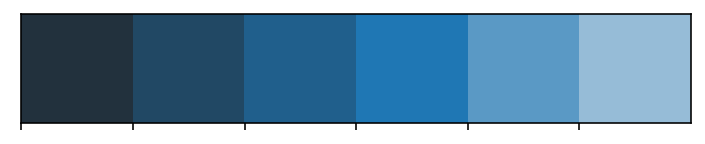

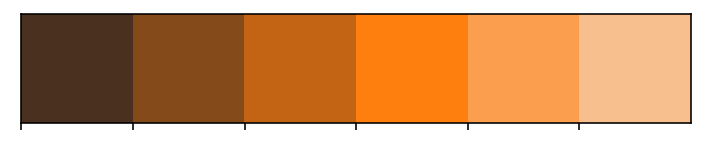

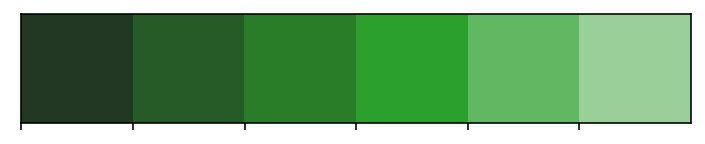

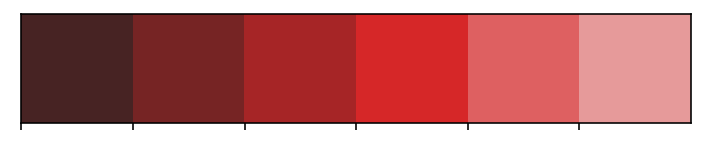

In [109]:
case_colours = np.empty(shape=(4, 6, 3), dtype="object")

maps = sns.color_palette("tab10", 4)
for i, m in enumerate(maps):
    darks = sns.dark_palette(m, 8)
    lights = sns.light_palette(m, 8, reverse=True)[1:]
    case_colours[i, :] = np.array(darks + lights)[1:-2:2]
    sns.palplot(case_colours[i, :])
    
case_colours = case_colours[:, 1:, :]

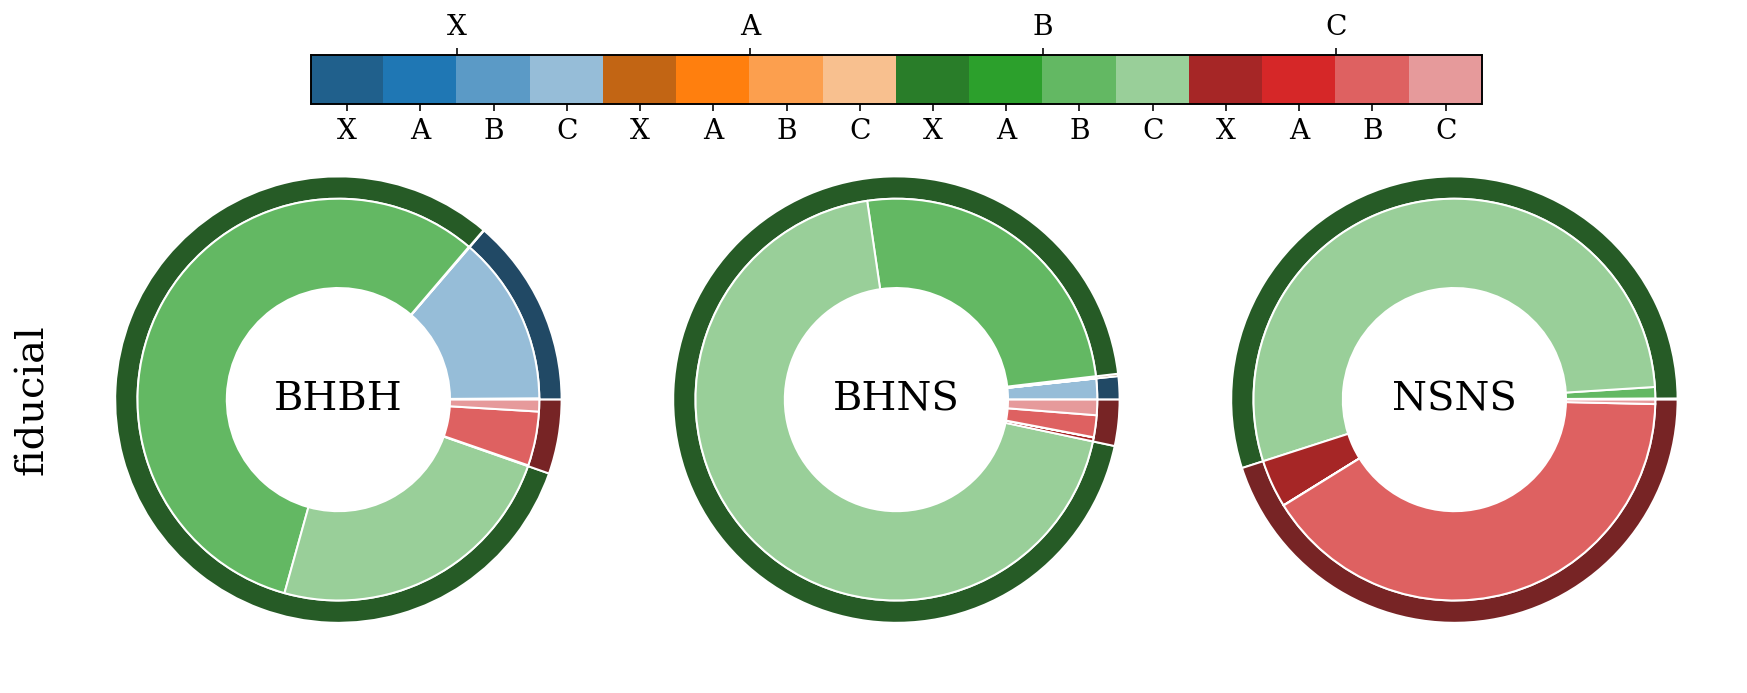

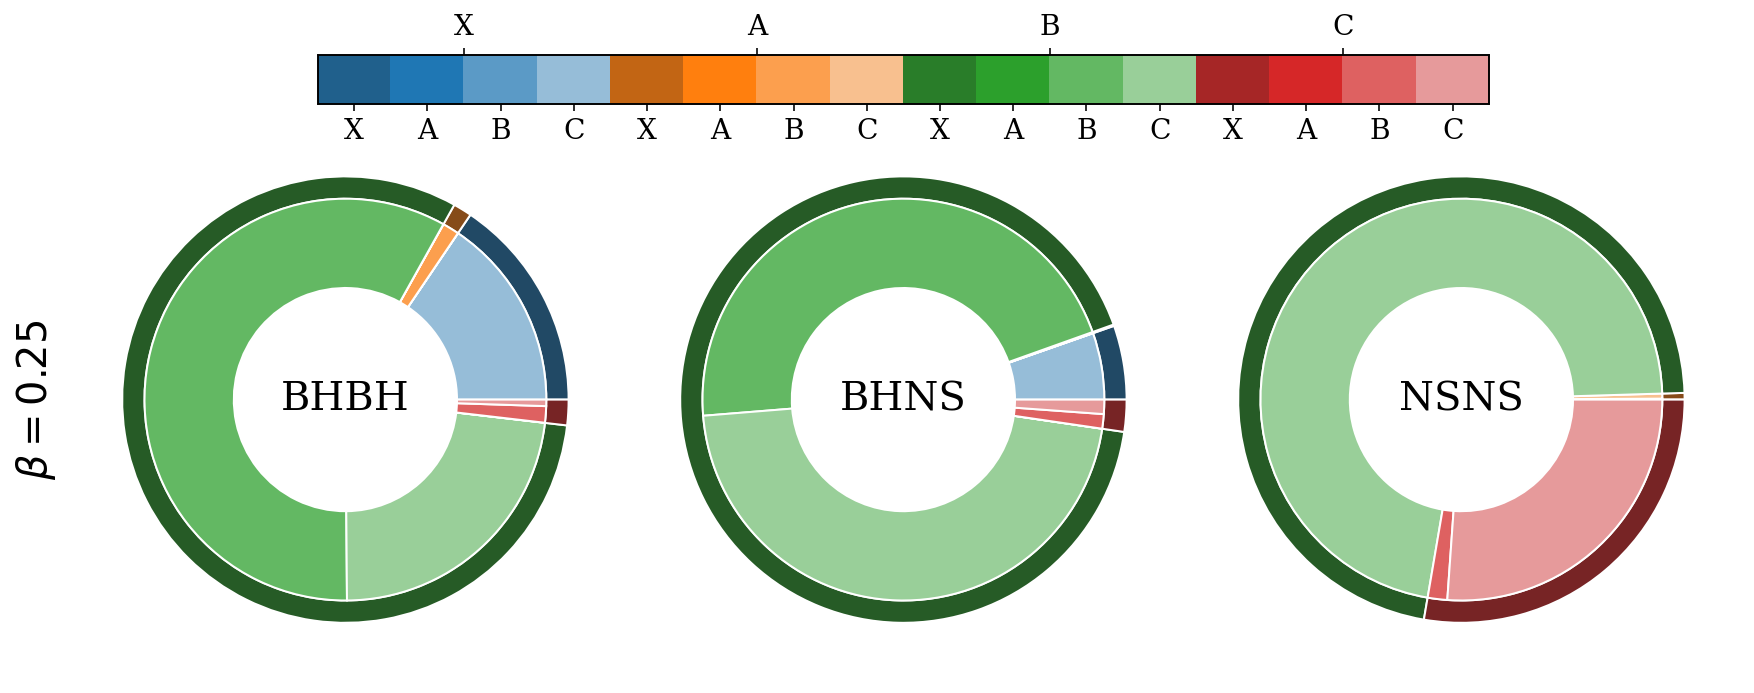

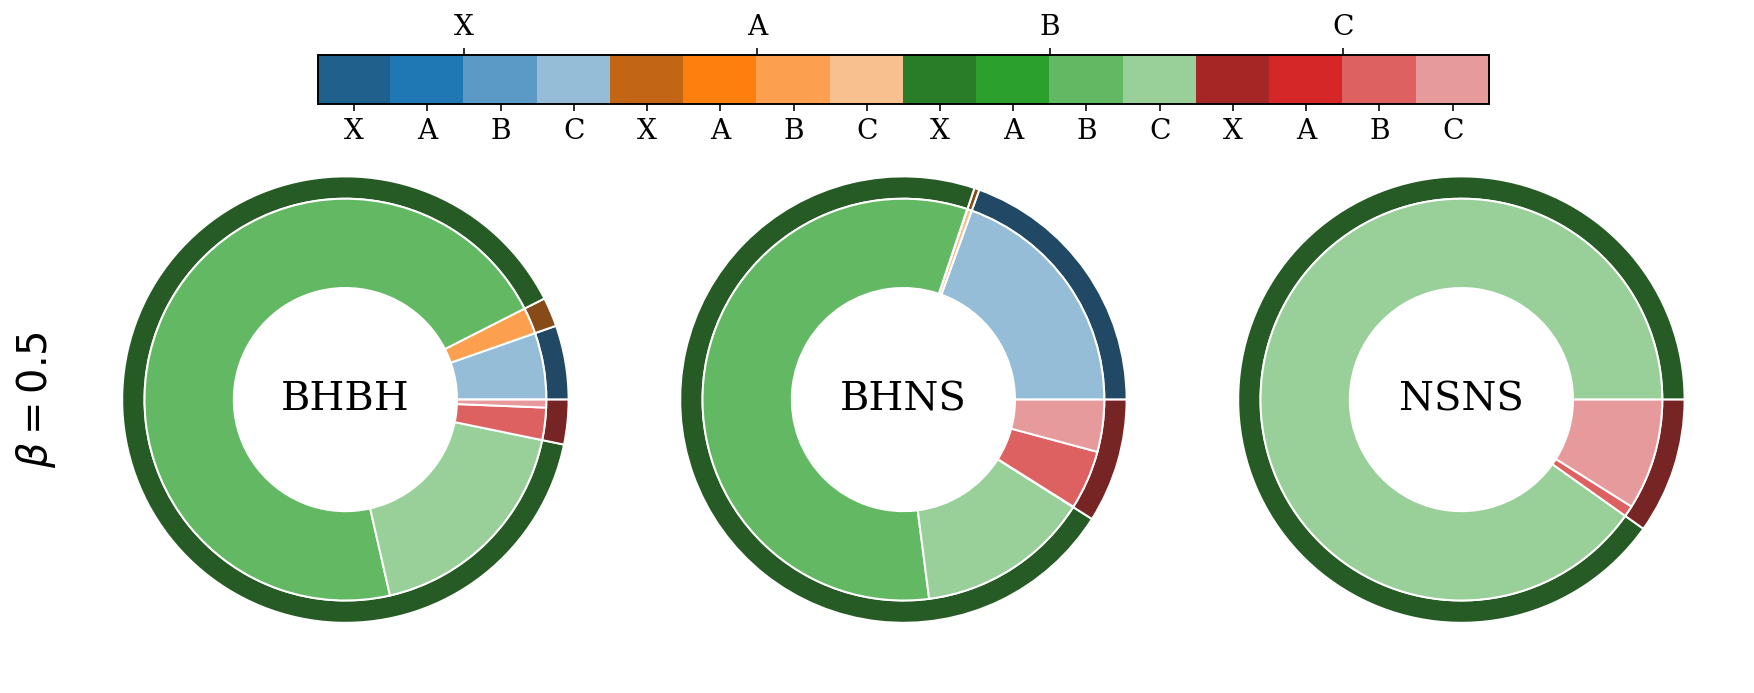

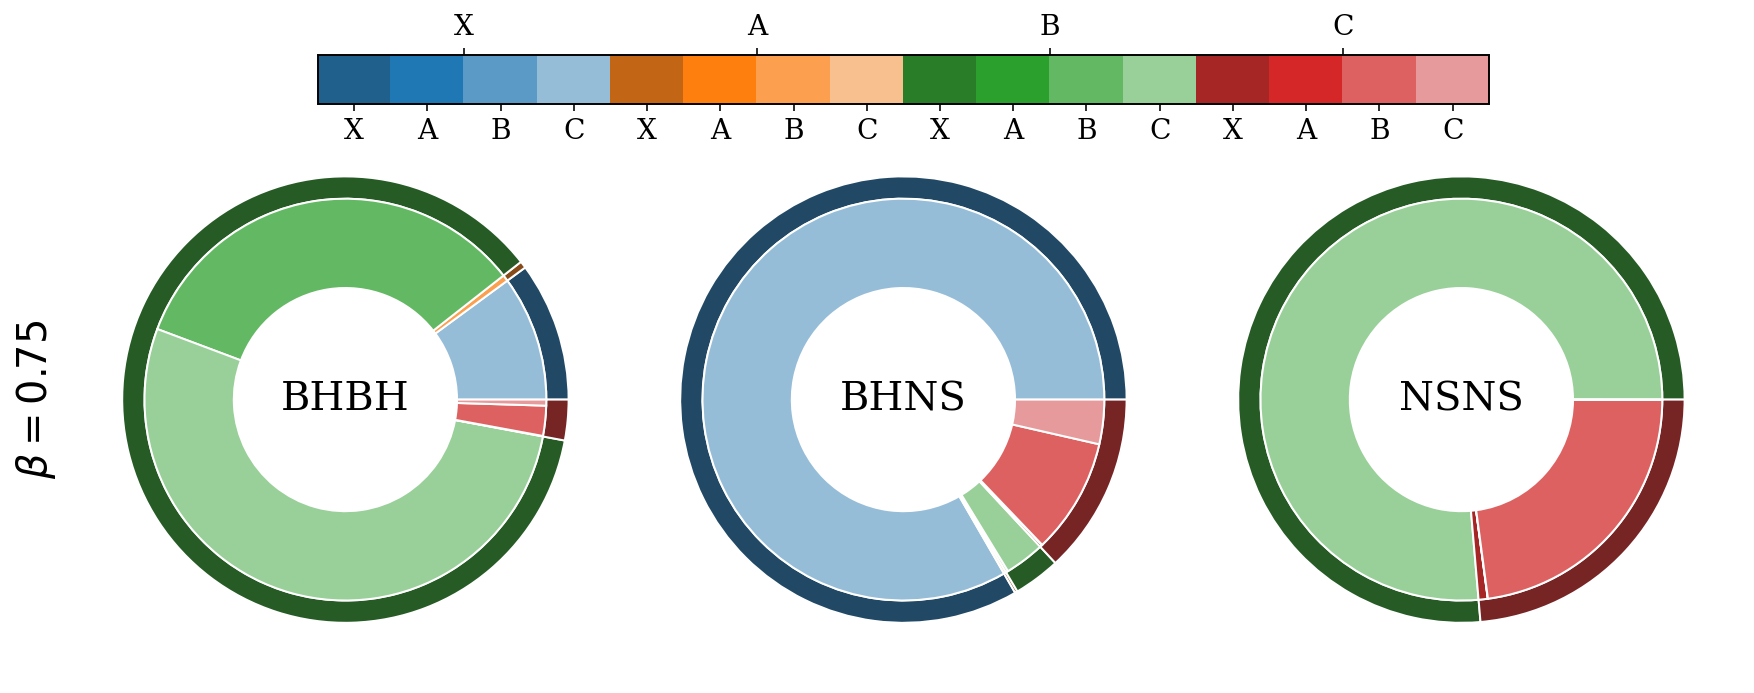

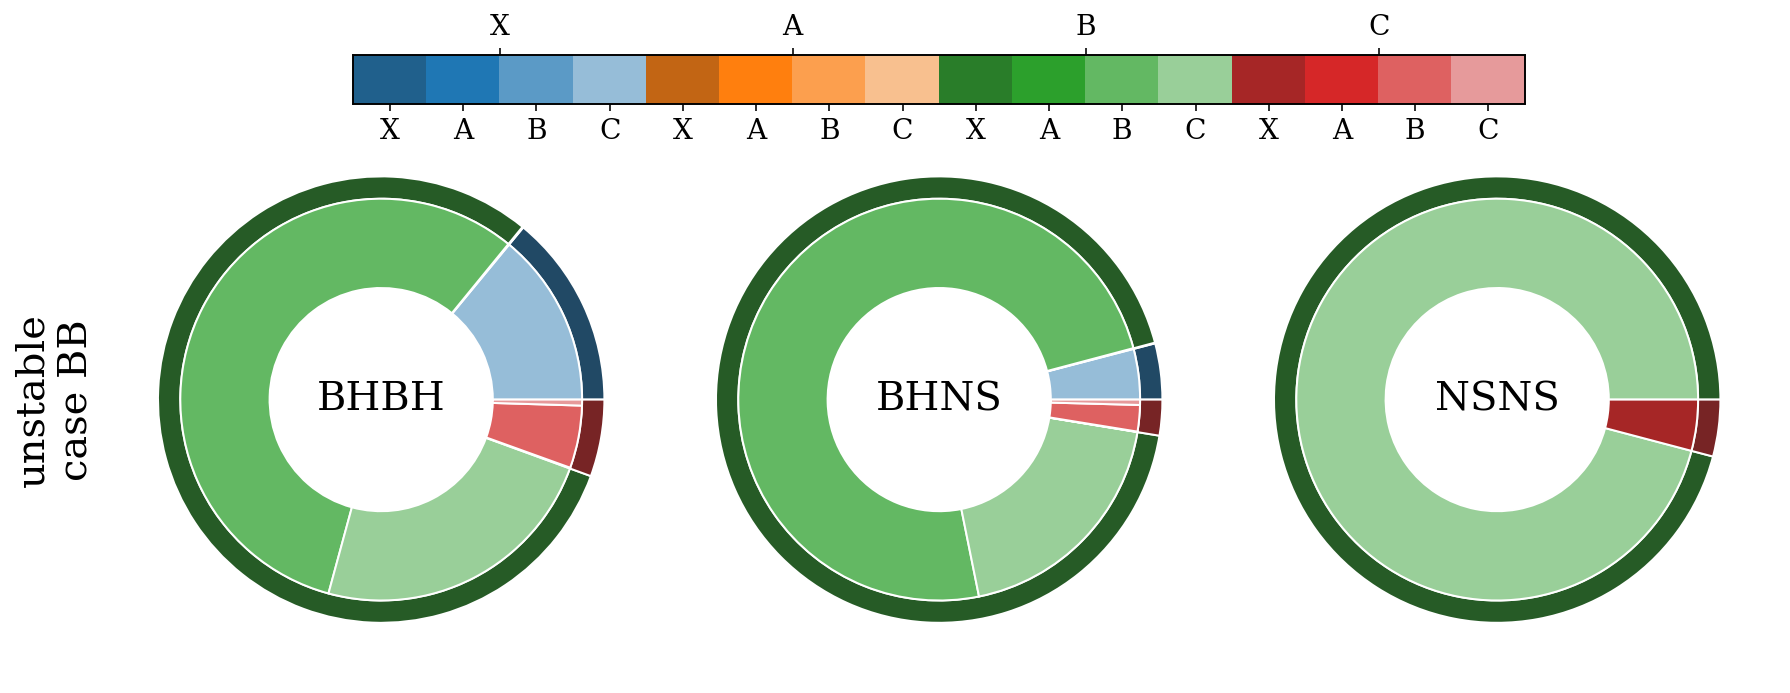

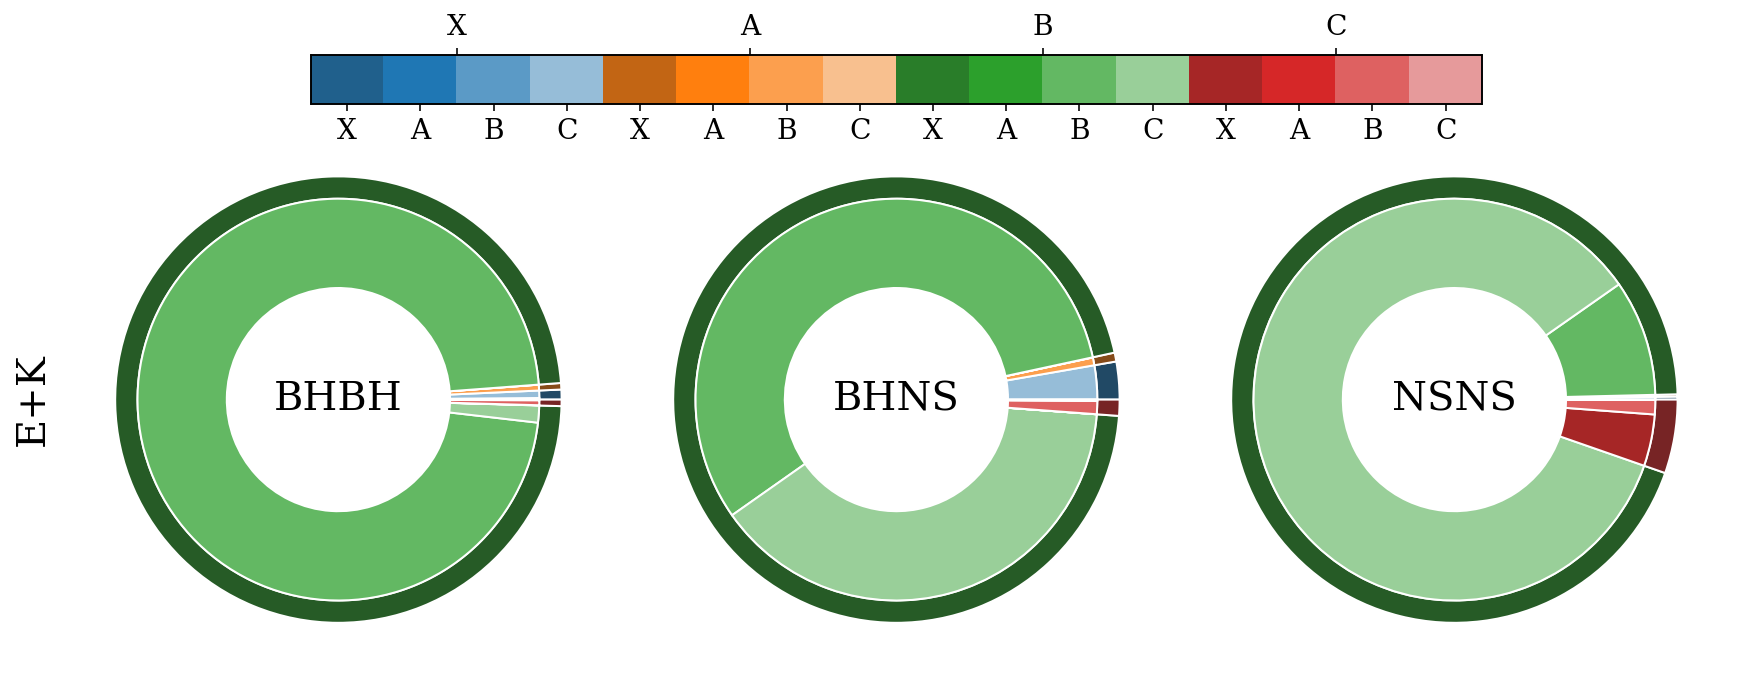

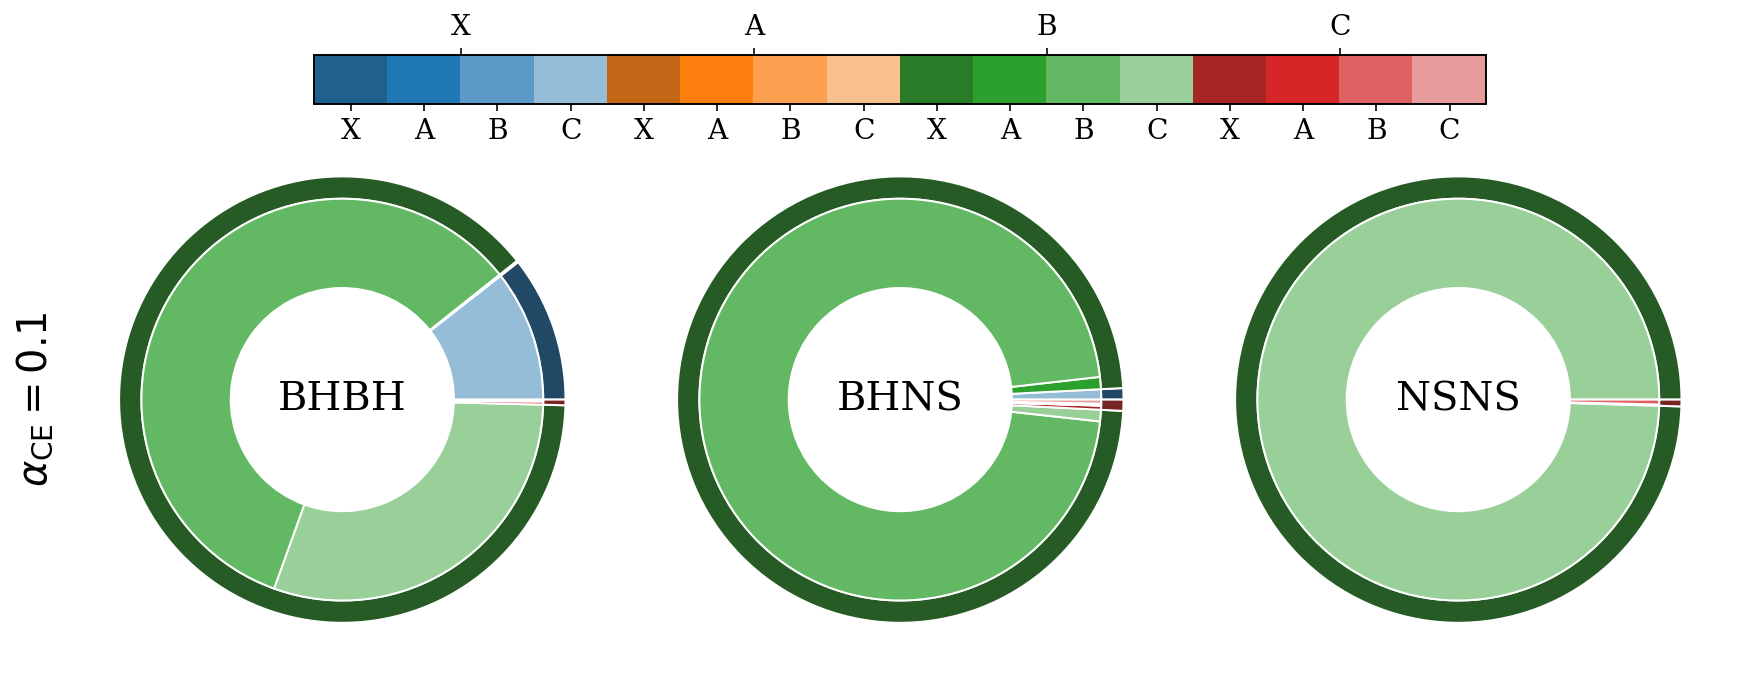

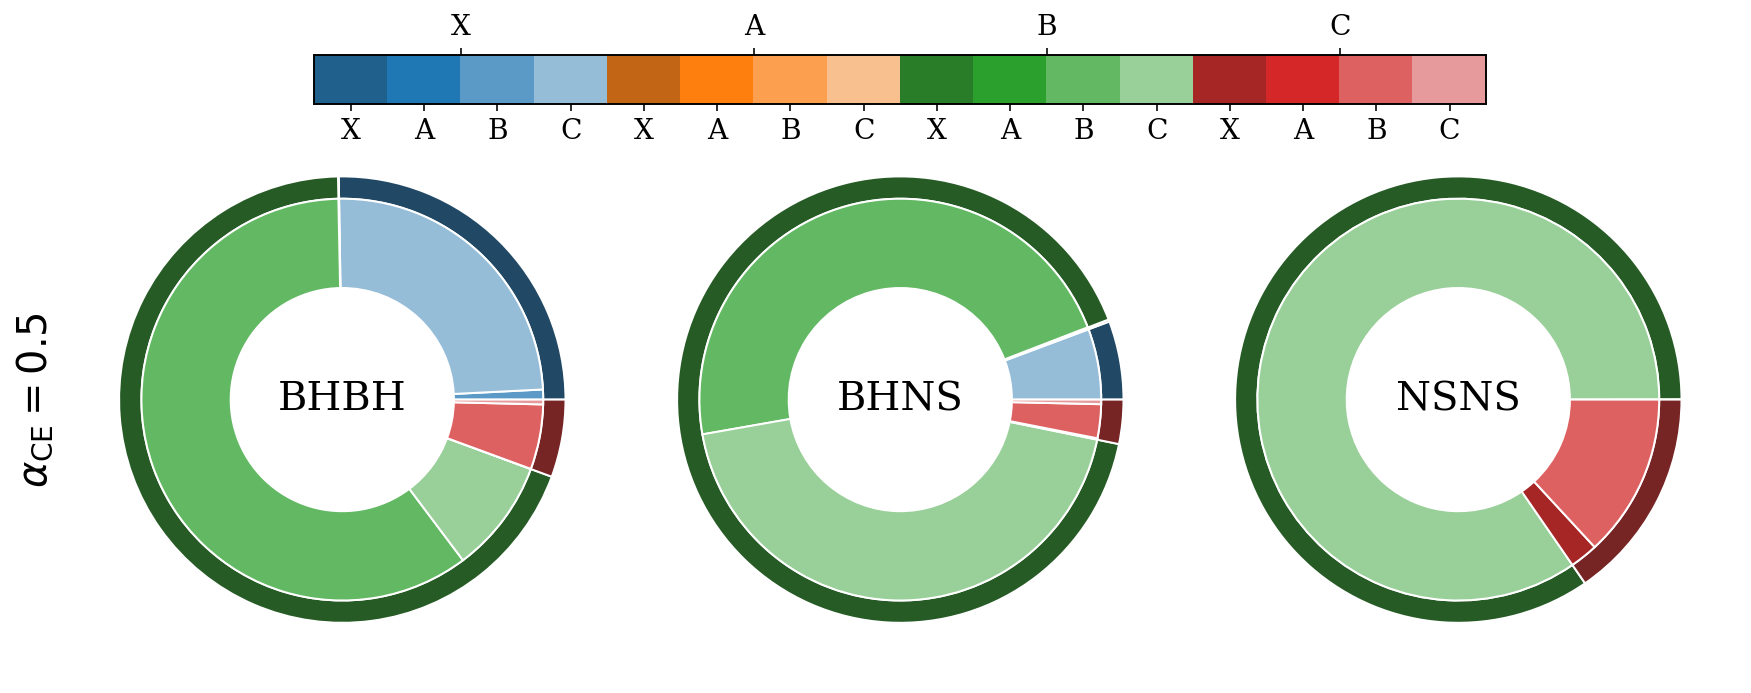

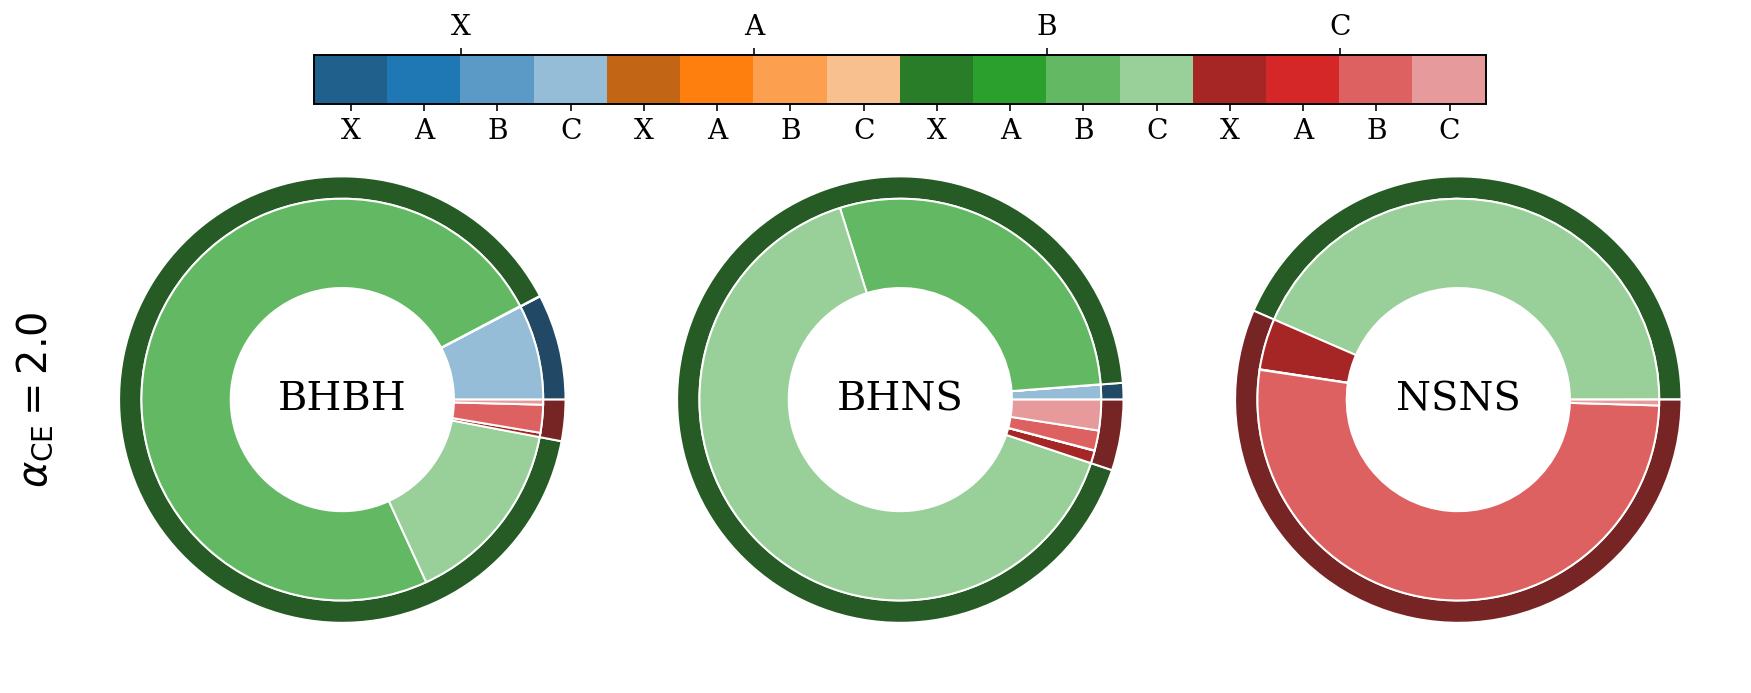

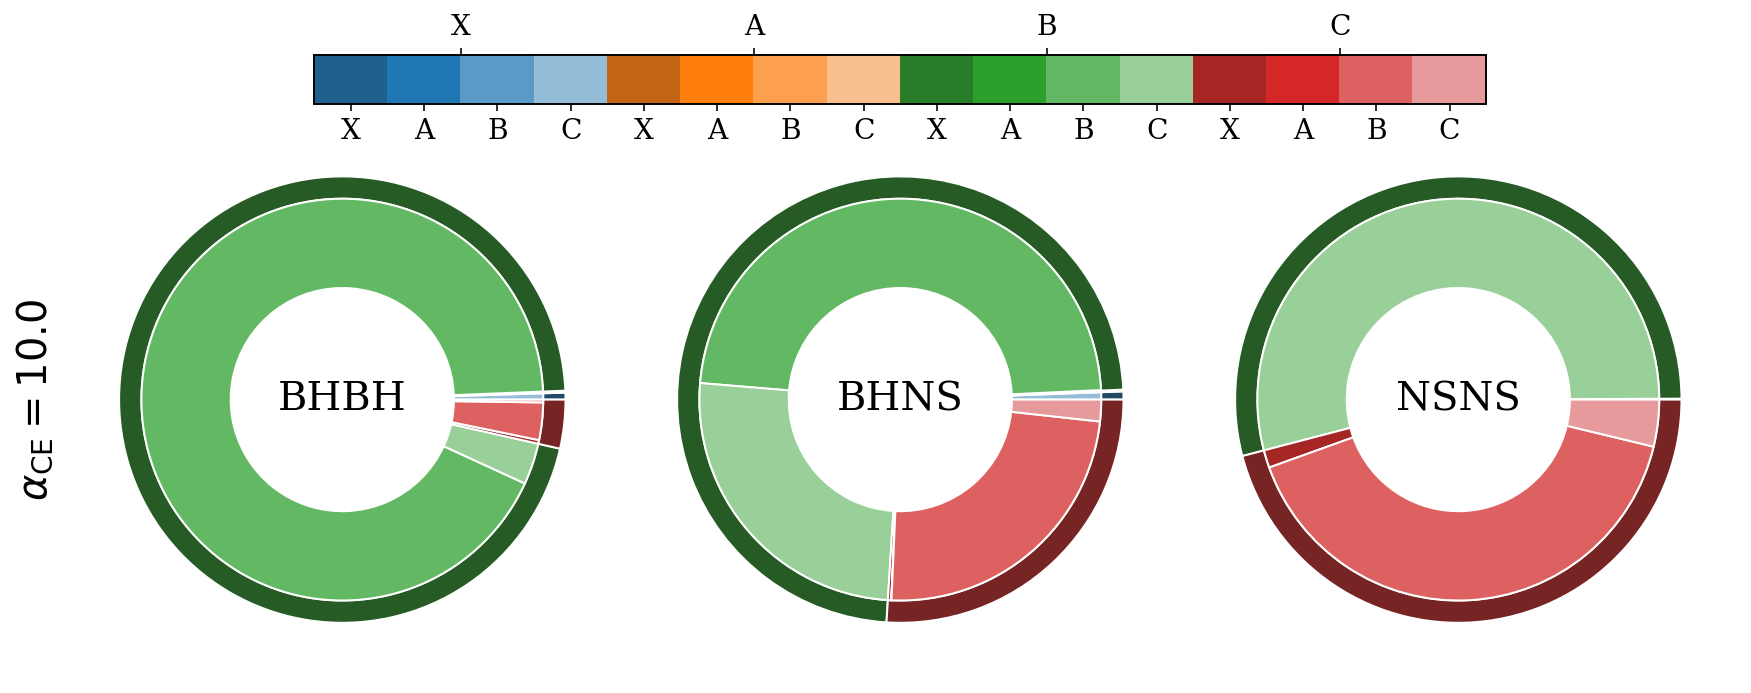

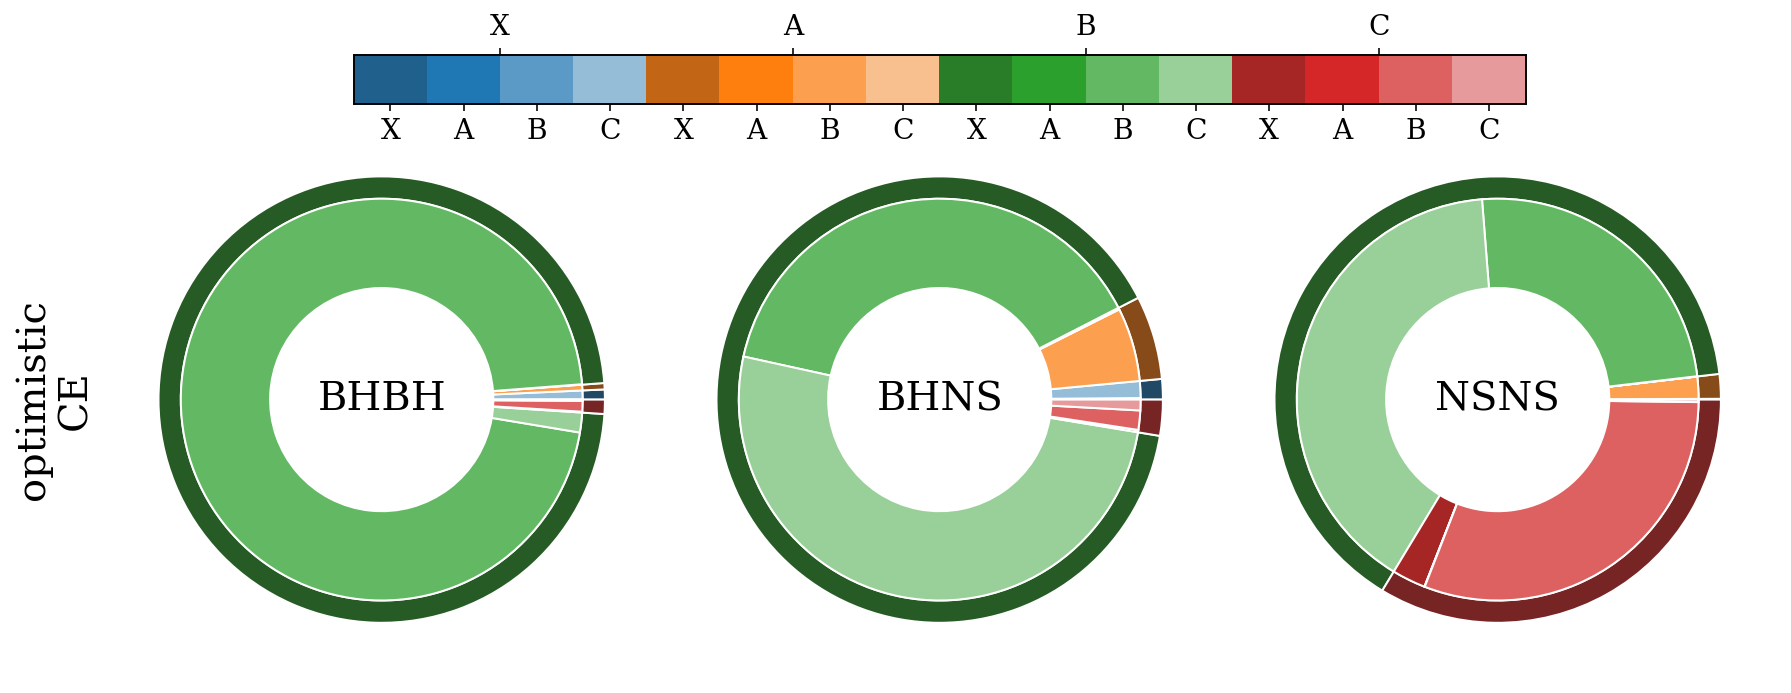

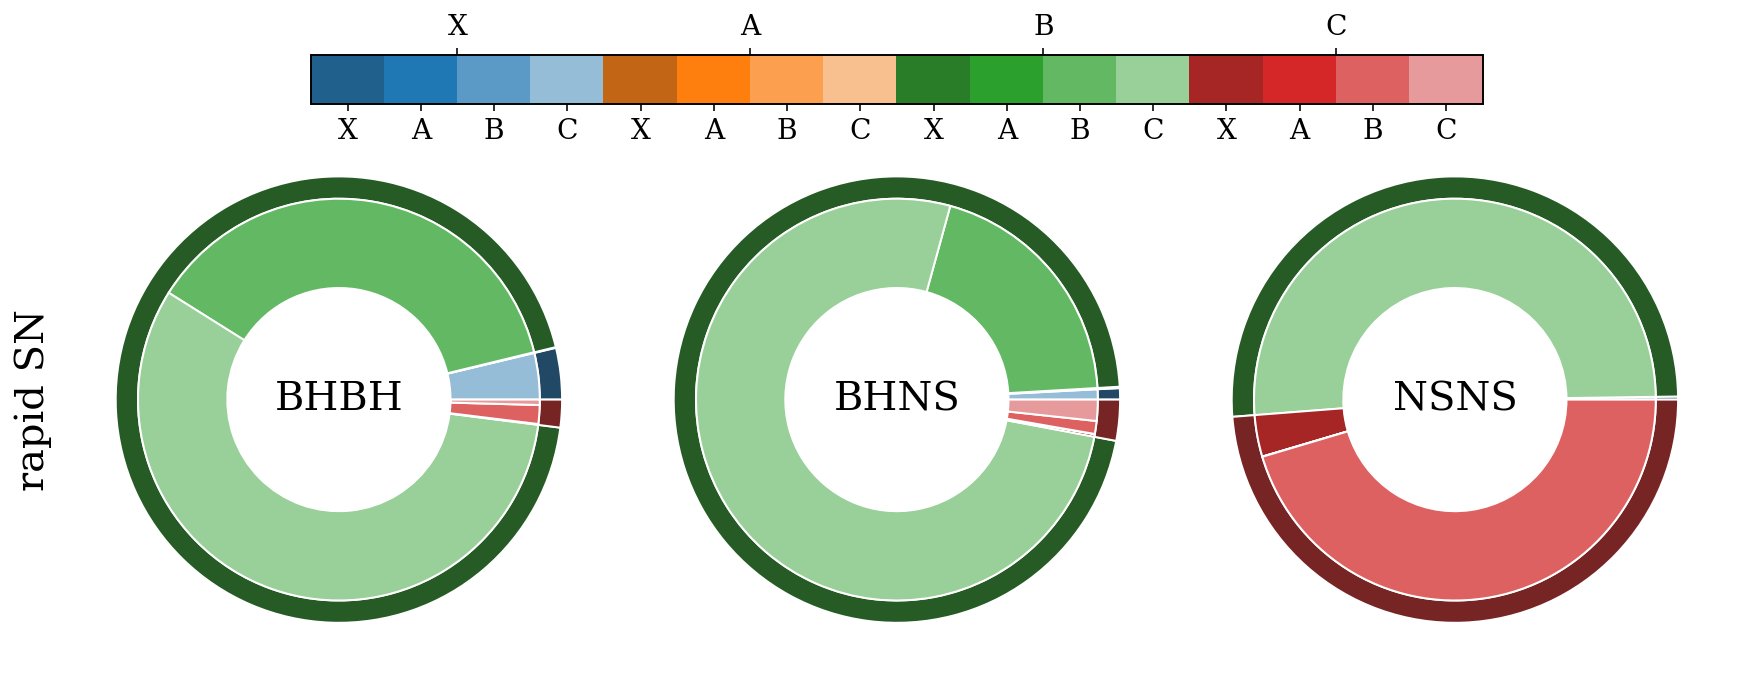

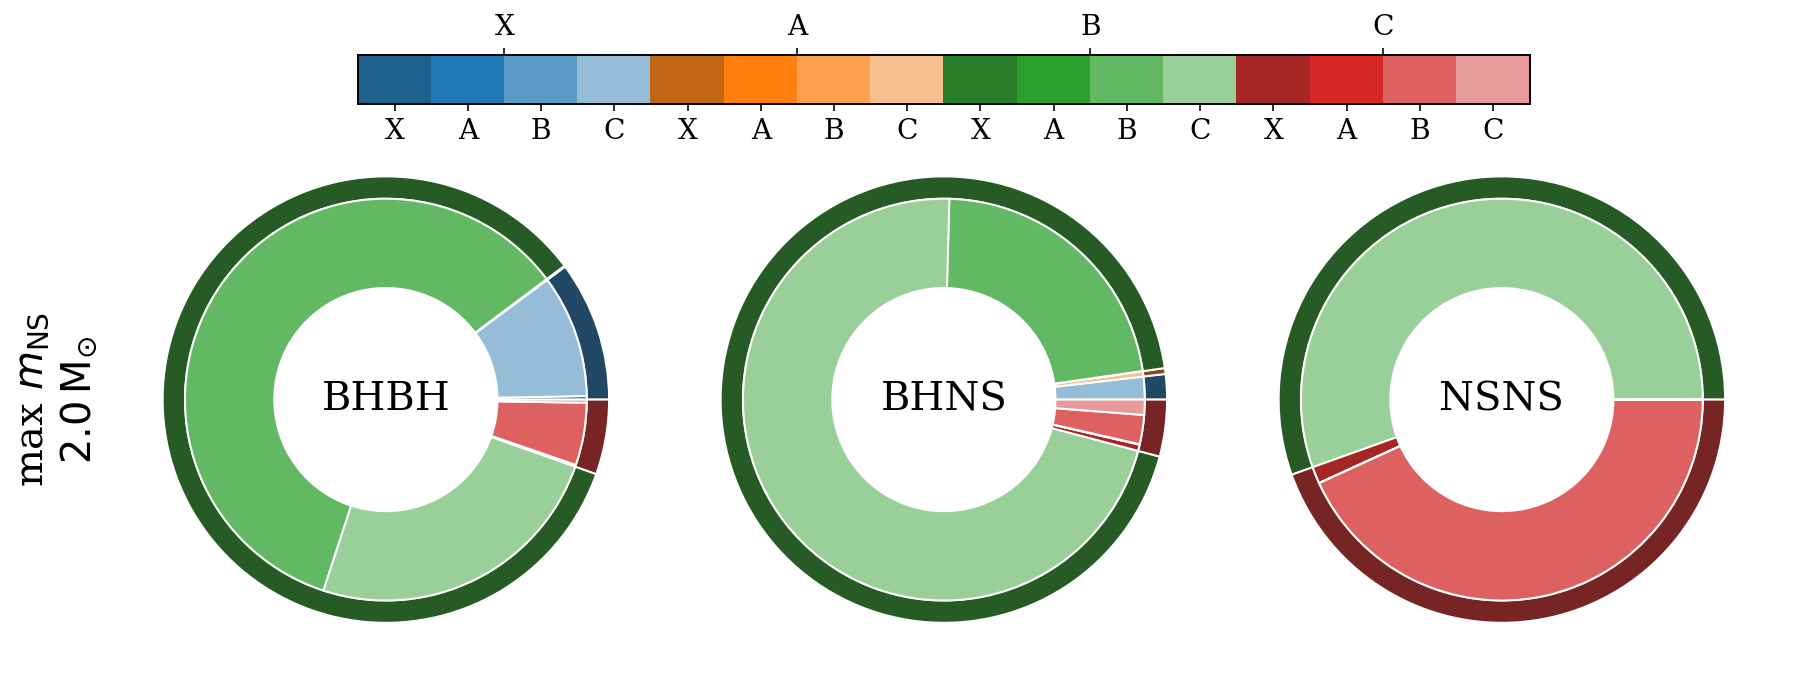

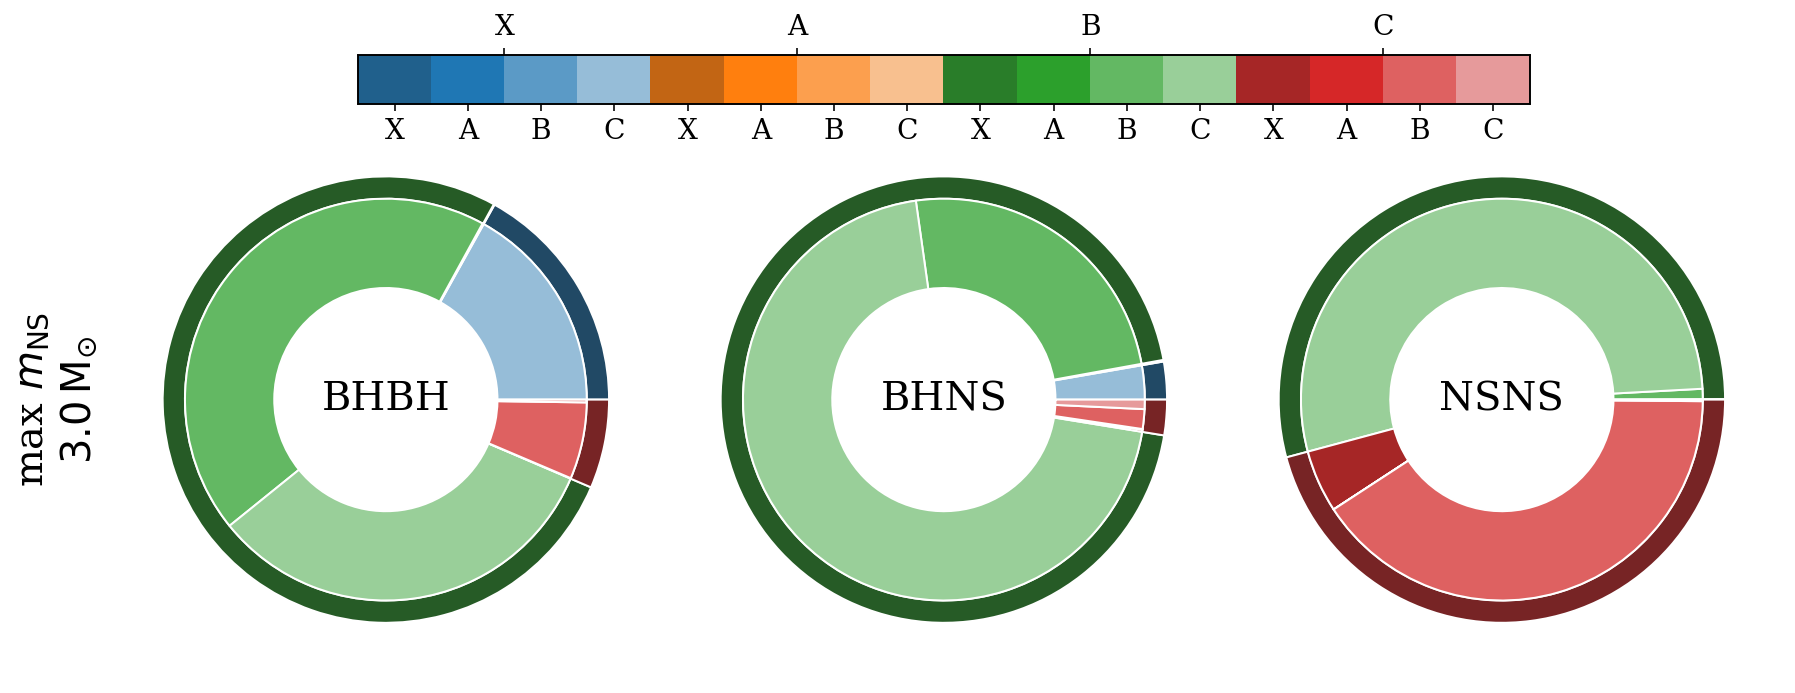

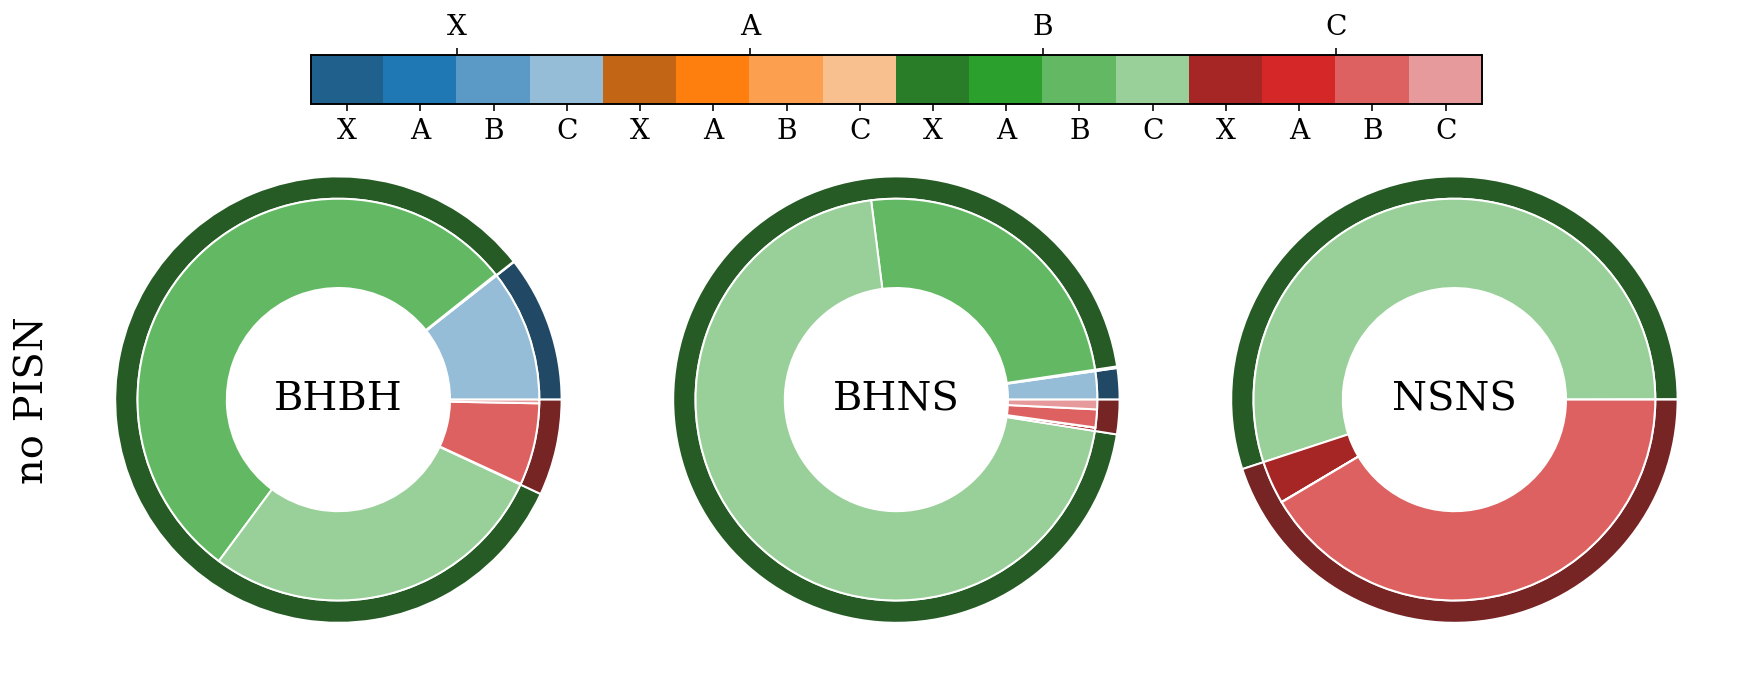

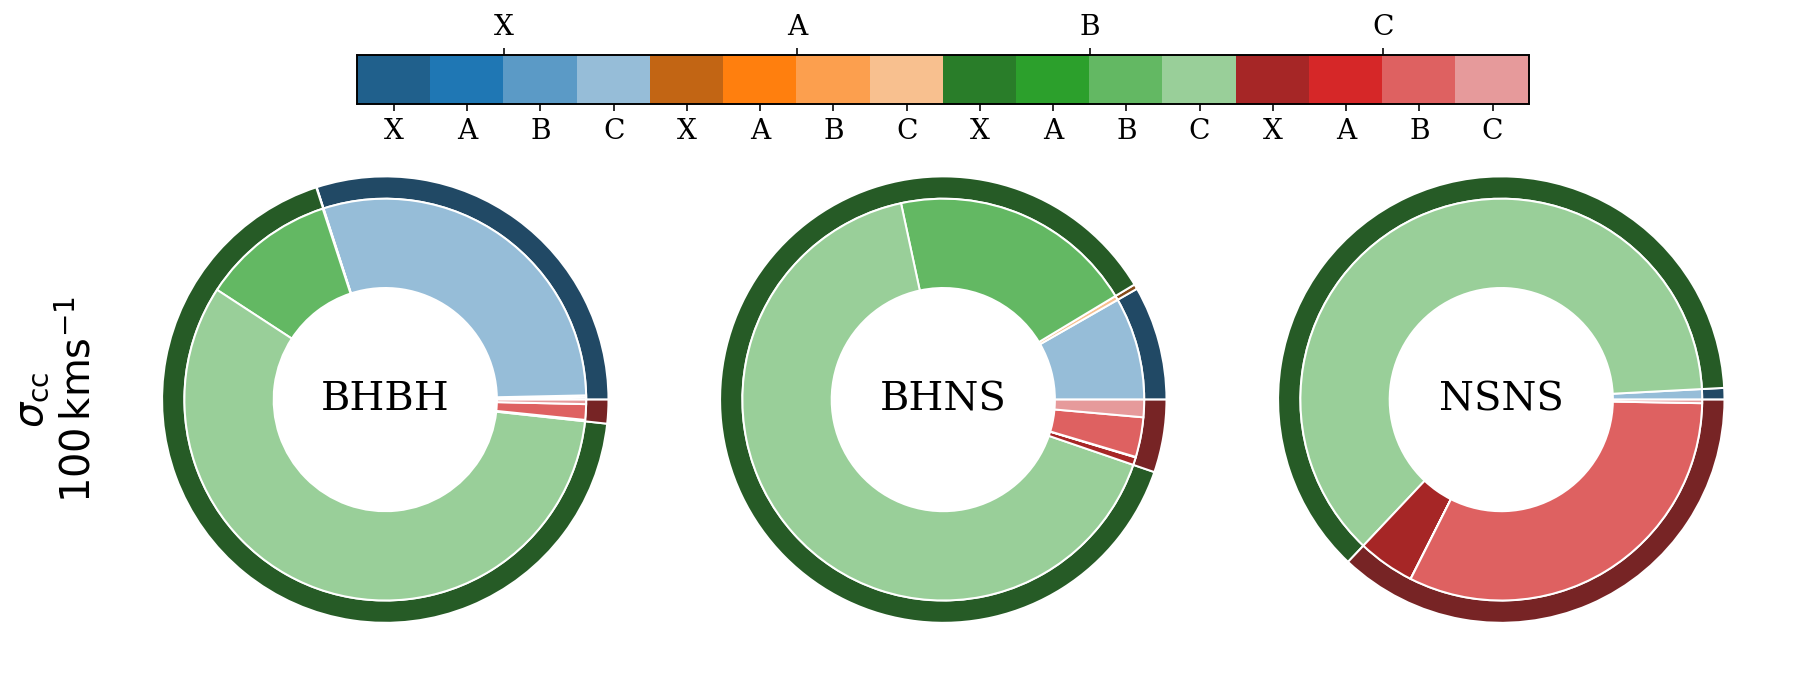

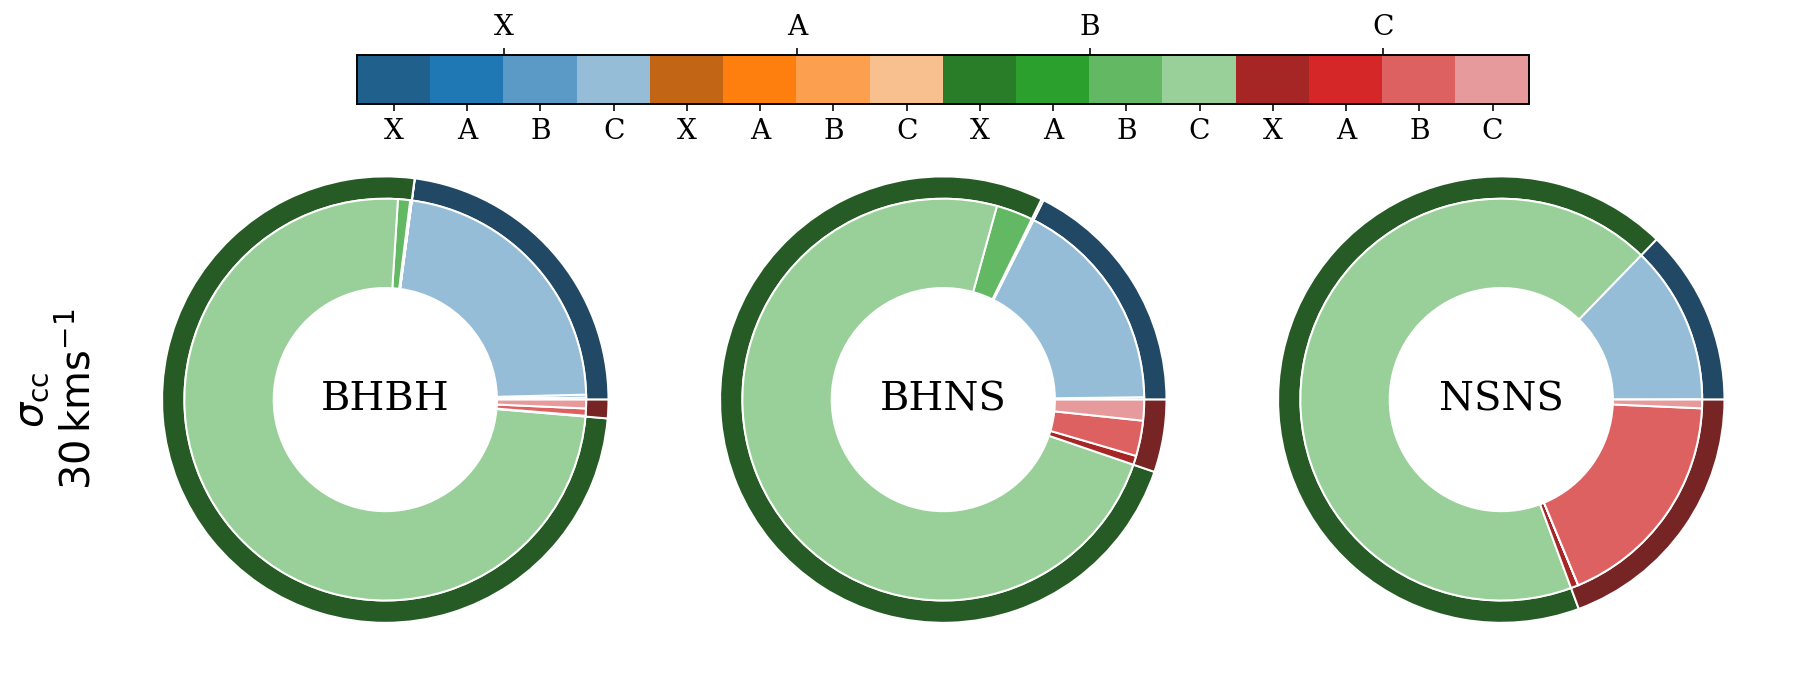

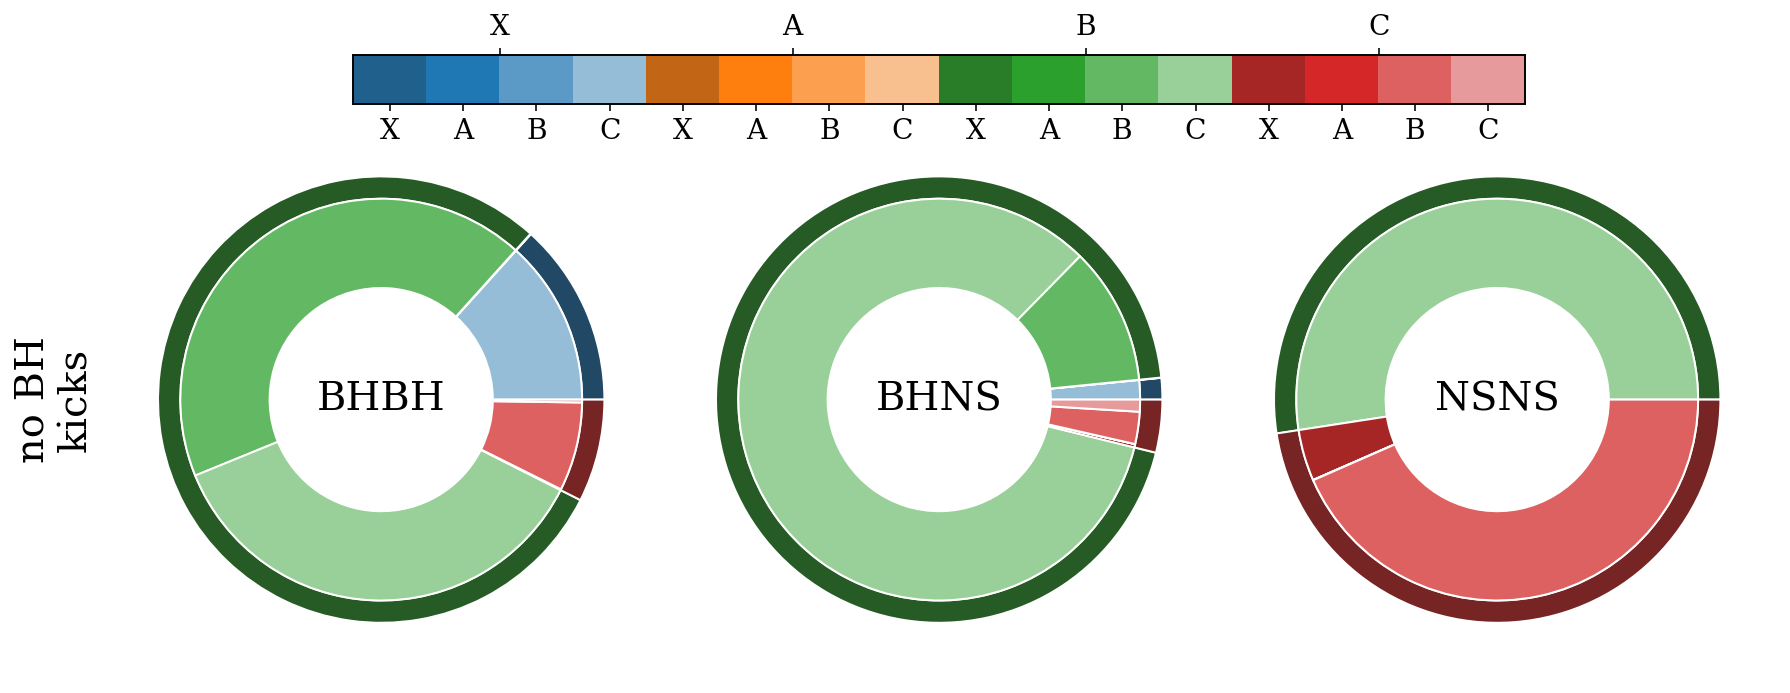

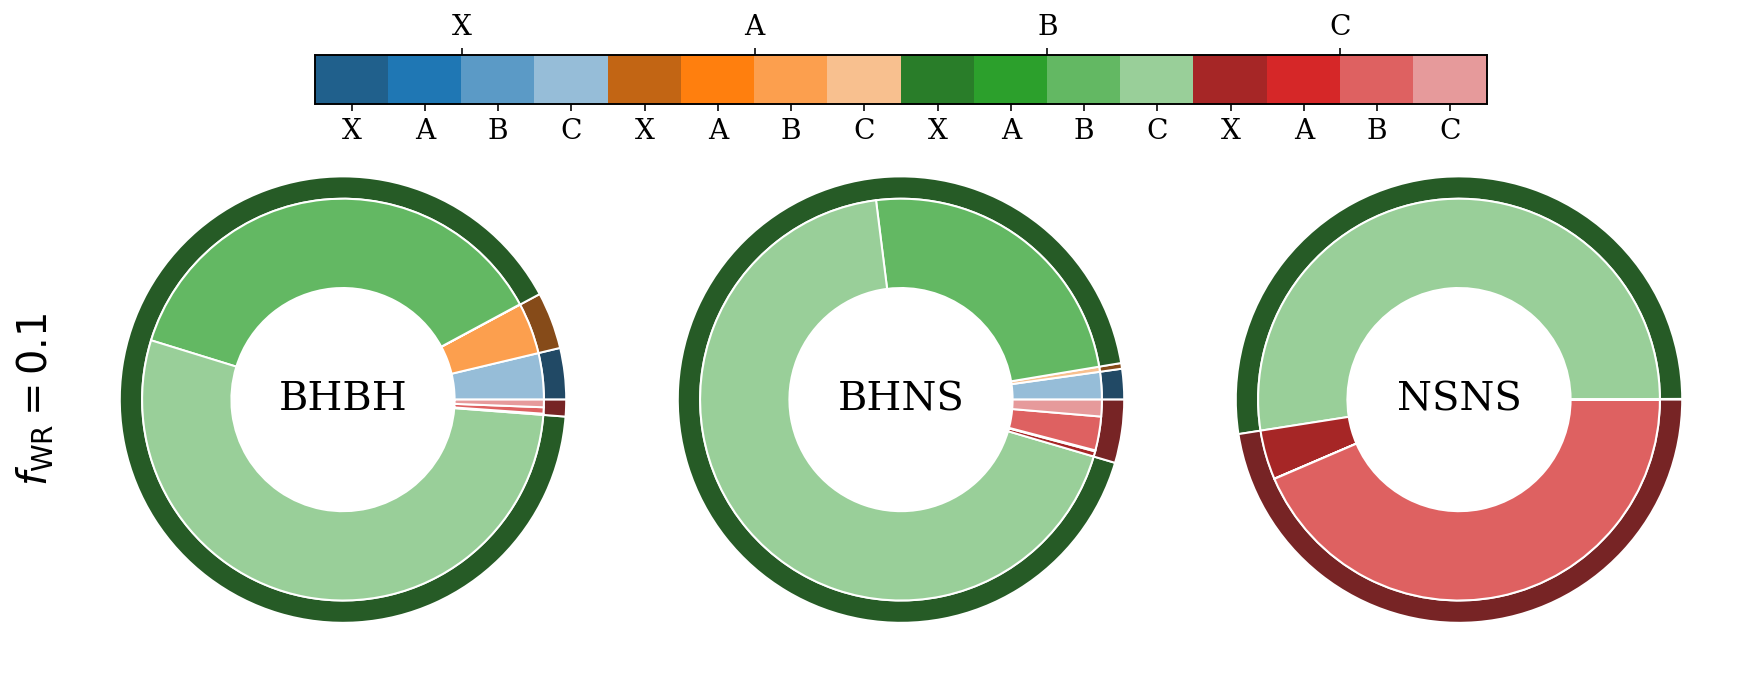

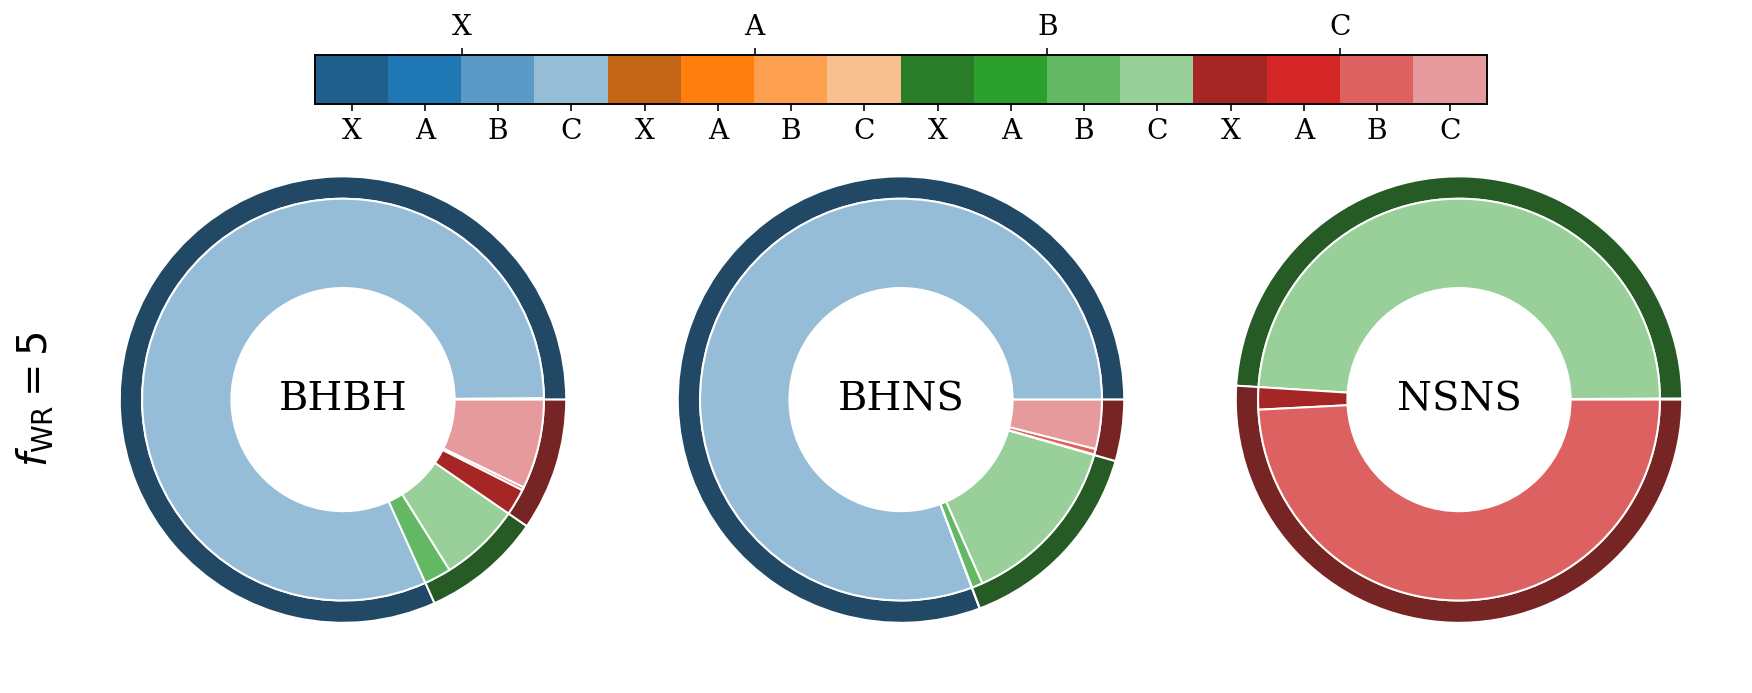

In [110]:
inner_colours = case_colours[:, 1:, :].reshape(16, 3)
outer_colours = case_colours[:, 0]

for model in range(len(variations)):
    fig, axes = plt.subplots(1, 3, figsize=(15, 15))
    fig.subplots_adjust(wspace=0.0)
    
    zero_colours = np.zeros((4, 4))
    
    for d in range(len(dco_types)):
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_types[d], variations[model]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            mask = full_data["snr"] > 7

            data = full_data[mask]

        fractions = np.zeros((4, 4))
        for case_mt1 in case_list:
            for case_mt2 in case_list:
                matches = np.logical_and(data["MT1_case"] == case_mt1,
                                          data["MT2_case"] == case_mt2)
                fractions[case_mt1, case_mt2] = np.sum(data["weight"][matches]) / np.sum(data["weight"])

        size = 0.1
        outer = fractions.sum(axis=1)
        outer_mask = outer > 0.00
        axes[d].pie(outer[outer_mask], radius=1, normalize=True,
                                            colors=outer_colours[outer_mask], wedgeprops=dict(width=size, edgecolor='w'))

        inner = fractions.flatten()
        inner_mask = inner > 0.00

        axes[d].pie(inner[inner_mask], radius=1 - size, normalize=True,
                                            colors=inner_colours[inner_mask], wedgeprops=dict(width=size * 4, edgecolor='w'))
        axes[d].annotate(dco_types[d], xy=(0, 0), ha="center", va="center", fontsize=fs)
        
        zero_colours += fractions
        
    zero_colours = zero_colours.flatten()

    cmap = matplotlib.colors.ListedColormap(case_colours[:, 1:, :].reshape(16, 3))
    cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), ax=axes, fraction=0.03, pad=0.01, location="top", shrink=0.7)
    cbar.set_ticks([x / 32 for x in range(1, 32, 2)])
    cbar.set_ticklabels(["X", "A", "B", "C"] * 4)
    cbar.ax.set_aspect("auto")
    
#     for i in range(len(zero_colours)):
#         if zero_colours[i] == 0.0:
#             x_coords = [(i + 0.1) / 16, (i + 0.9) / 16]
#             cbar.ax.plot(x_coords, [0.1, 0.9], color="black")
#             cbar.ax.plot(x_coords, [0.9, 0.1], color="black")

    ax2 = cbar.ax.twiny()
    ax2.set_xticks([1/8, 3/8, 5/8, 7/8])
    ax2.set_xticklabels(["X", "A", "B", "C"])
    
    axes[0].set_ylabel(variations[model]["med"])

    # plt.savefig("../../paper/figures/MT_cases_fiducial.png", dpi=1200, bbox_inches="tight")

    plt.show()

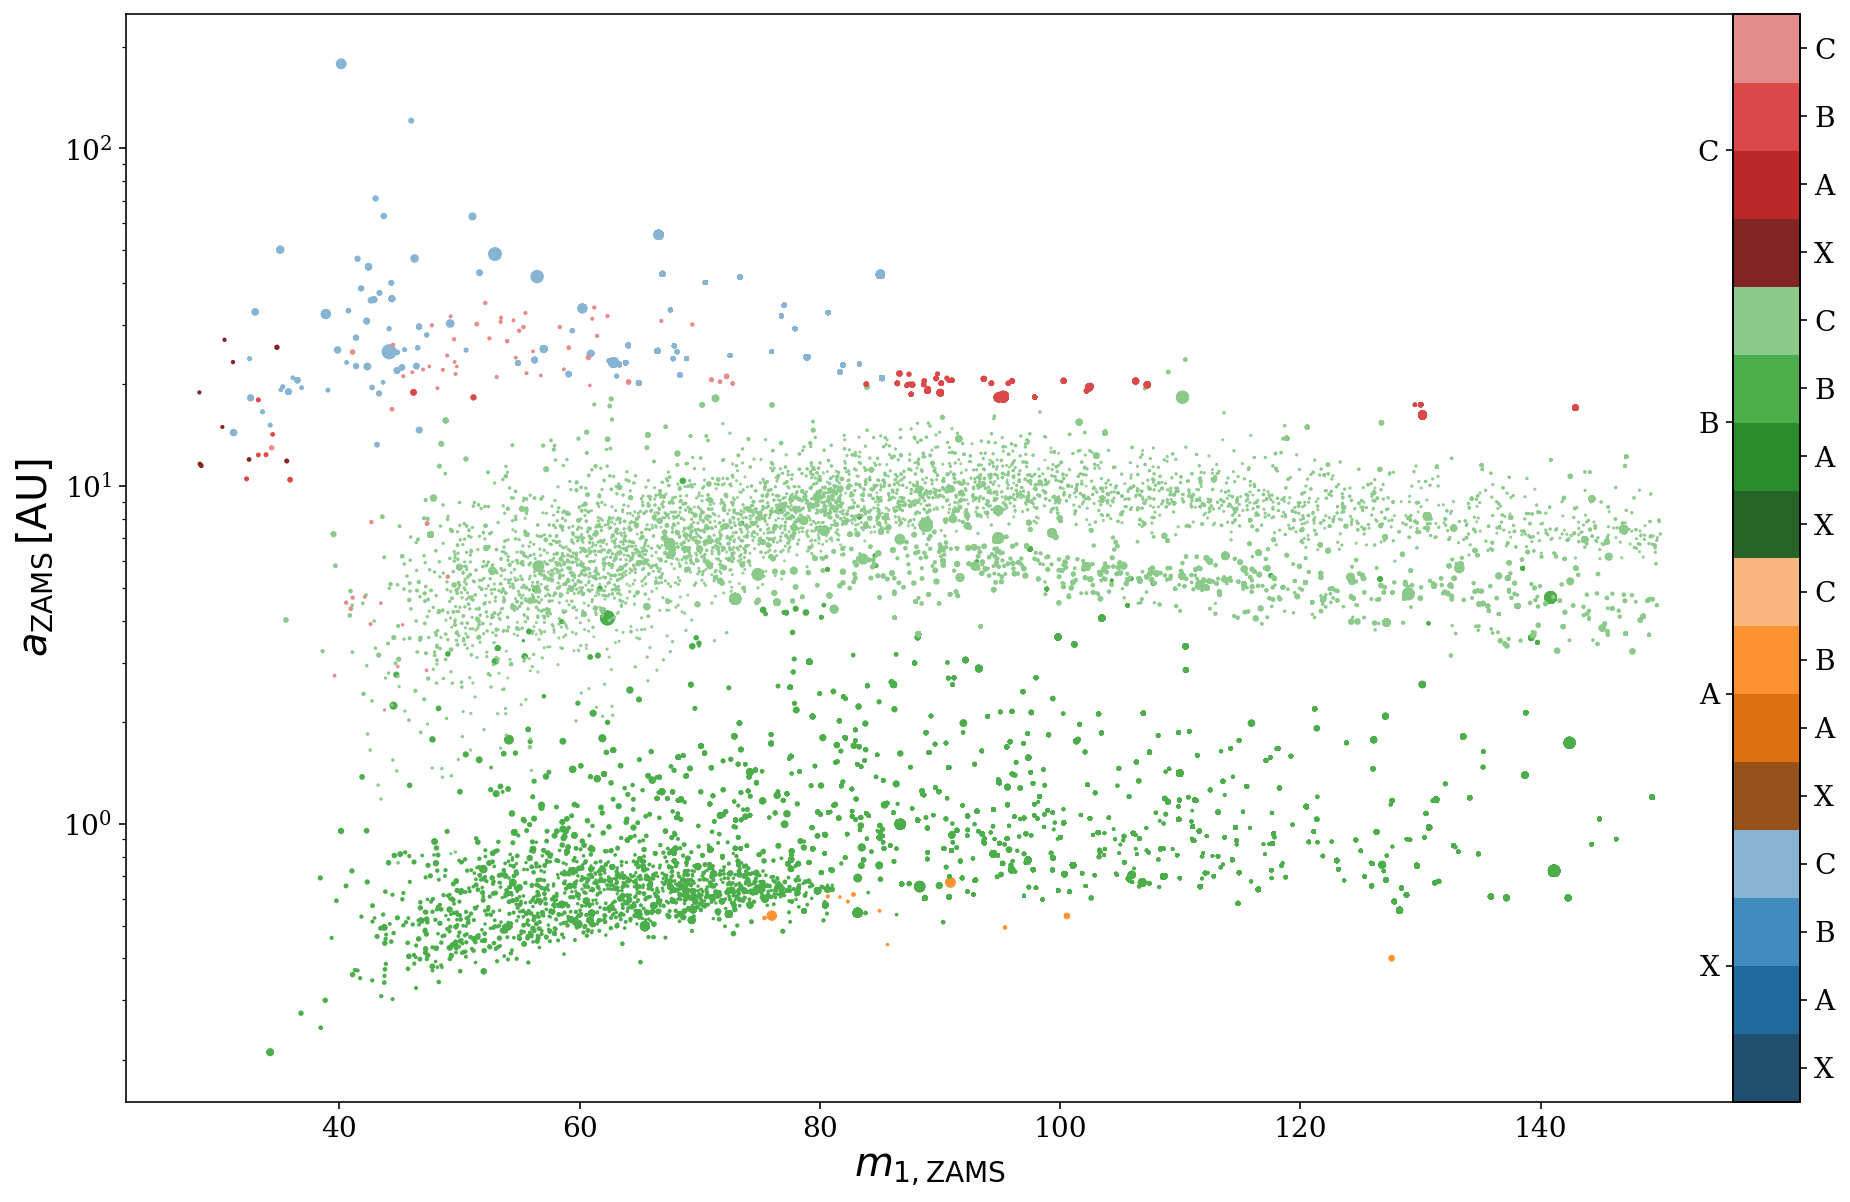

In [104]:
fig, ax = plt.subplots(figsize=(15, 10))

model = 0

with h5.File(sim_folder + "{}_{}_all.h5".format("BHBH", variations[model]["file"]), "r") as f:
    full_data = f["simulation"][...].squeeze()
    snr_mask = full_data["snr"] > 7

    data = full_data[snr_mask]

m1 = np.maximum(data["m_1_ZAMS"], data["m_2_ZAMS"])
m2 = np.minimum(data["m_1_ZAMS"], data["m_2_ZAMS"])
q = m2 / m1

for case in case_list:
    for case2 in case_list:
        mask = np.logical_and(data["MT1_case"] == case,
                              data["MT2_case"] == case2)

        ax.scatter(m1[mask], data["a_ZAMS"][mask], s=data["weight"][mask] * 50, color=case_colours[case, case2 + 1])#, label=case_labels[(case * 4) + case2])

cmap = matplotlib.colors.ListedColormap(case_colours[:, 1:, :].reshape(16, 3))
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), fraction=0.04, pad=0.0)
cbar.set_ticks([1/8, 3/8, 5/8, 7/8])
cbar.set_ticklabels(["X", "A", "B", "C"])
cbar.ax.set_aspect("auto")

ax2 = cbar.ax.twinx()
ax2.set_yticks([x / 32 for x in range(1, 32, 2)])
ax2.set_yticklabels(["X", "A", "B", "C"] * 4)

ax.set_yscale("log")

ax.set_xlabel(r"$m_{1, \rm ZAMS}$")
ax.set_ylabel(r"$a_{\rm ZAMS}\, [\rm AU]$")

plt.savefig("../../paper/figures/BHBH_q_a_ZAMS_cases.png", dpi=400)

plt.show()

In [3]:
def kdeplot_by_channel(variable, dco_type_list=["BHBH", "BHNS", "NSNS"], channels=[0, 1, 2, 3, 4], variation_index=0, show=True, fig=None, ax=None, **kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 5))

    for dco_type in dco_type_list:
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[variation_index]["file"]), "r") as f:
            full_data = f["simulation"][...].squeeze()
            mask = np.logical_and(full_data["snr"] > 7, np.isin(full_data["channel"], channels))

            data = full_data[mask]
            print(len(data))

        sns.kdeplot(data[variable], weights=data["weight"], color=dco_colours[dco_type], cut=0, **kwargs, ax=ax)

    if show:
        print("yo")
        plt.show()
    return fig, ax

# Eccentricity stuff

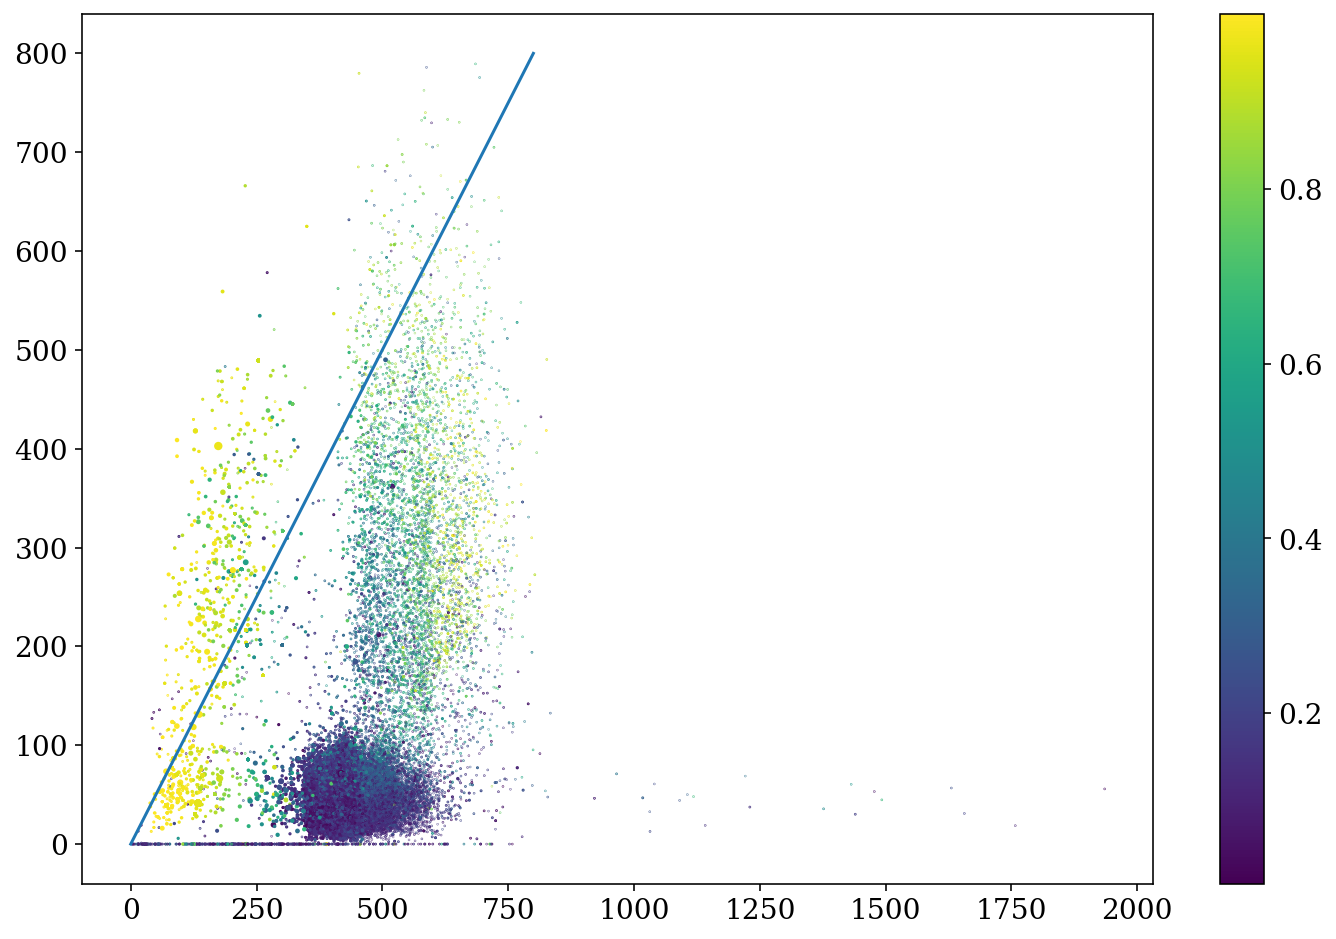

In [142]:
for dco_type in ["BHNS"]:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()
        
    P = (1 / legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun, a=data["a_pre_SN2"] * u.AU)).to(u.s)
    a2 = data["m_1"] / (data["m_1"] + data["m_2"]) * data["a_pre_SN2"] * u.AU
    v2 = 2 * np.pi / P * a2
    
    for i in [1, 2]:
        mask = data["channel"] == i
        scatter = plt.scatter(v2[mask].to(u.km / u.s).value, data["kick_2"][mask], s=data["weight"][mask] * 10, c=data["e_DCO"][mask])
        
# plt.plot([1e-2, 1e2], [1e-2, 1e2])
plt.plot([0, 800], [0, 800])
plt.colorbar(scatter)

# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(1e-4, 1)    

plt.show()

[617.28209265 514.93318651 555.97009688 ... 186.03316709 149.17535501
 159.6611302 ] km / s


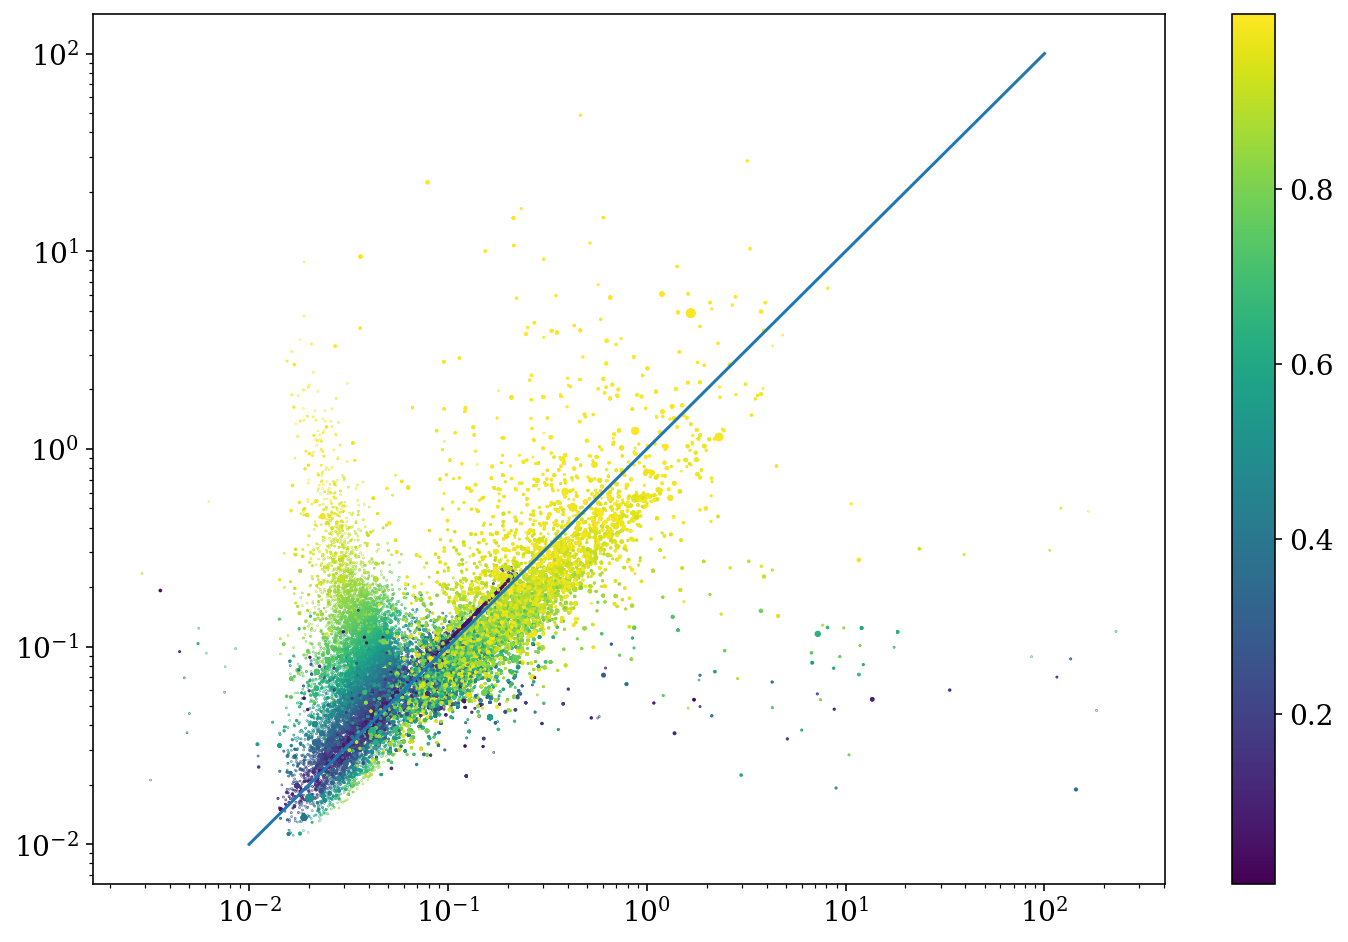

In [120]:
for dco_type in ["BHBH"]:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "fiducial"), "r") as f:
        data = f["simulation"][...].squeeze()
        
    P = (1 / legwork.utils.get_f_orb_from_a(m_1=data["m_1"] * u.Msun, m_2=data["m_2"] * u.Msun, a=data["a_pre_SN2"] * u.AU)).to(u.s)
    a2 = data["m_1"] / (data["m_1"] + data["m_2"]) * data["a_pre_SN2"] * u.AU
    v2 = 2 * np.pi / P * a2
    print(v2.to(u.km / u.s))

    for i in [1, 2]:
        mask = data["channel"] == i
        scatter = plt.scatter(data["a_pre_SN2"][mask], data["a_DCO"][mask], s=data["weight"][mask] * 10, c=data["e_DCO"][mask])
    
plt.plot([1e-2, 1e2], [1e-2, 1e2])
plt.colorbar(scatter)

plt.xscale("log")
plt.yscale("log")
# plt.xlim(1e-4, 1)

plt.show()

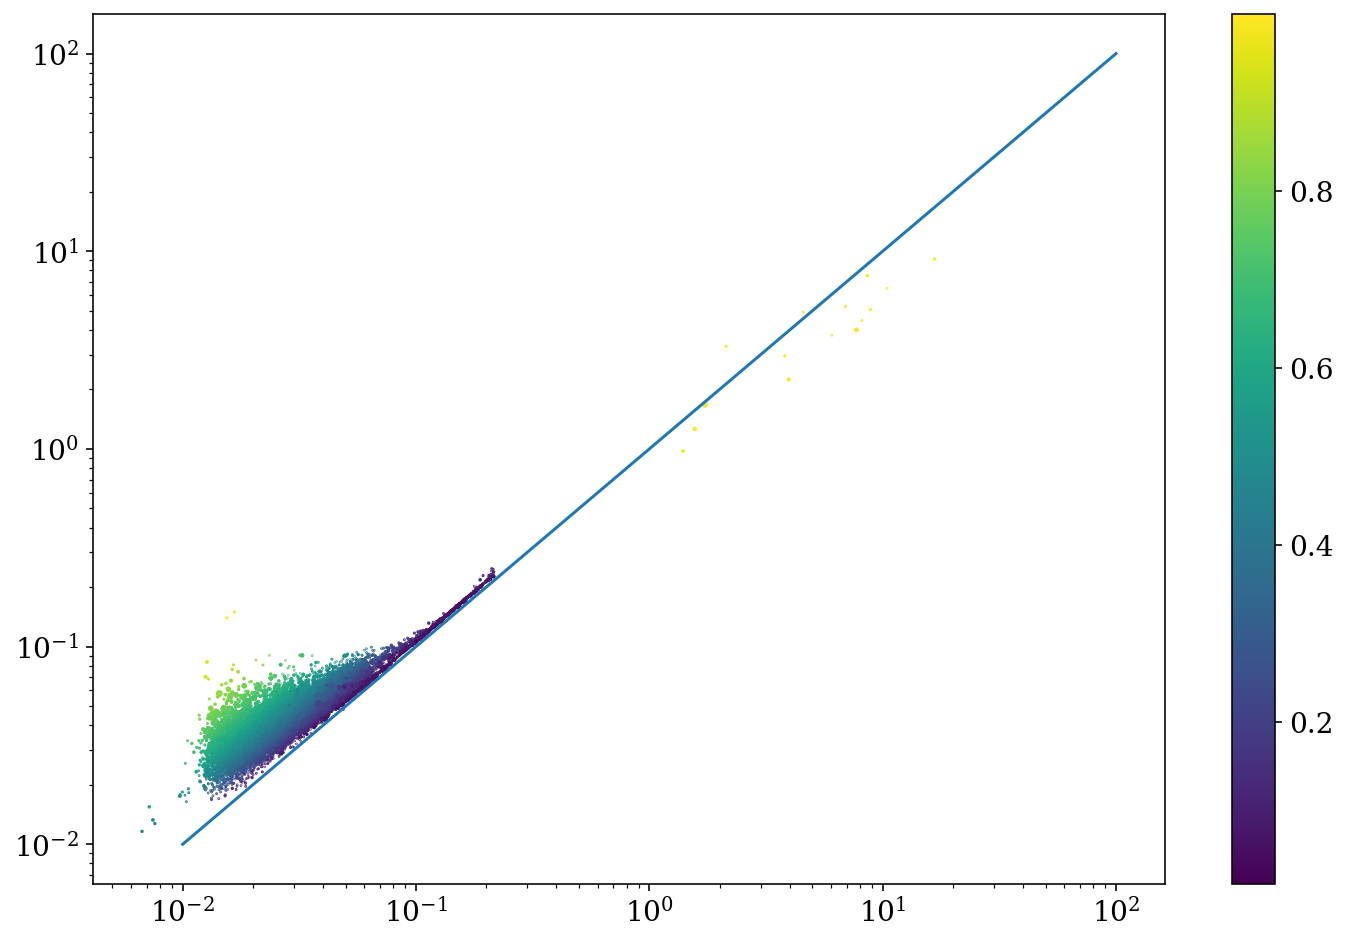

In [114]:
for dco_type in ["BHBH"]:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "ccSNkick_30km_s"), "r") as f:
        data = f["simulation"][...].squeeze()

    for i in [1, 2]:
        mask = data["channel"] == i
        scatter = plt.scatter(data["a_pre_SN2"][mask], data["a_DCO"][mask], s=data["weight"][mask] * 10, c=data["e_DCO"][mask])
    
plt.plot([1e-2, 1e2], [1e-2, 1e2])
plt.colorbar(scatter)

plt.xscale("log")
plt.yscale("log")
# plt.xlim(1e-4, 1)

plt.show()

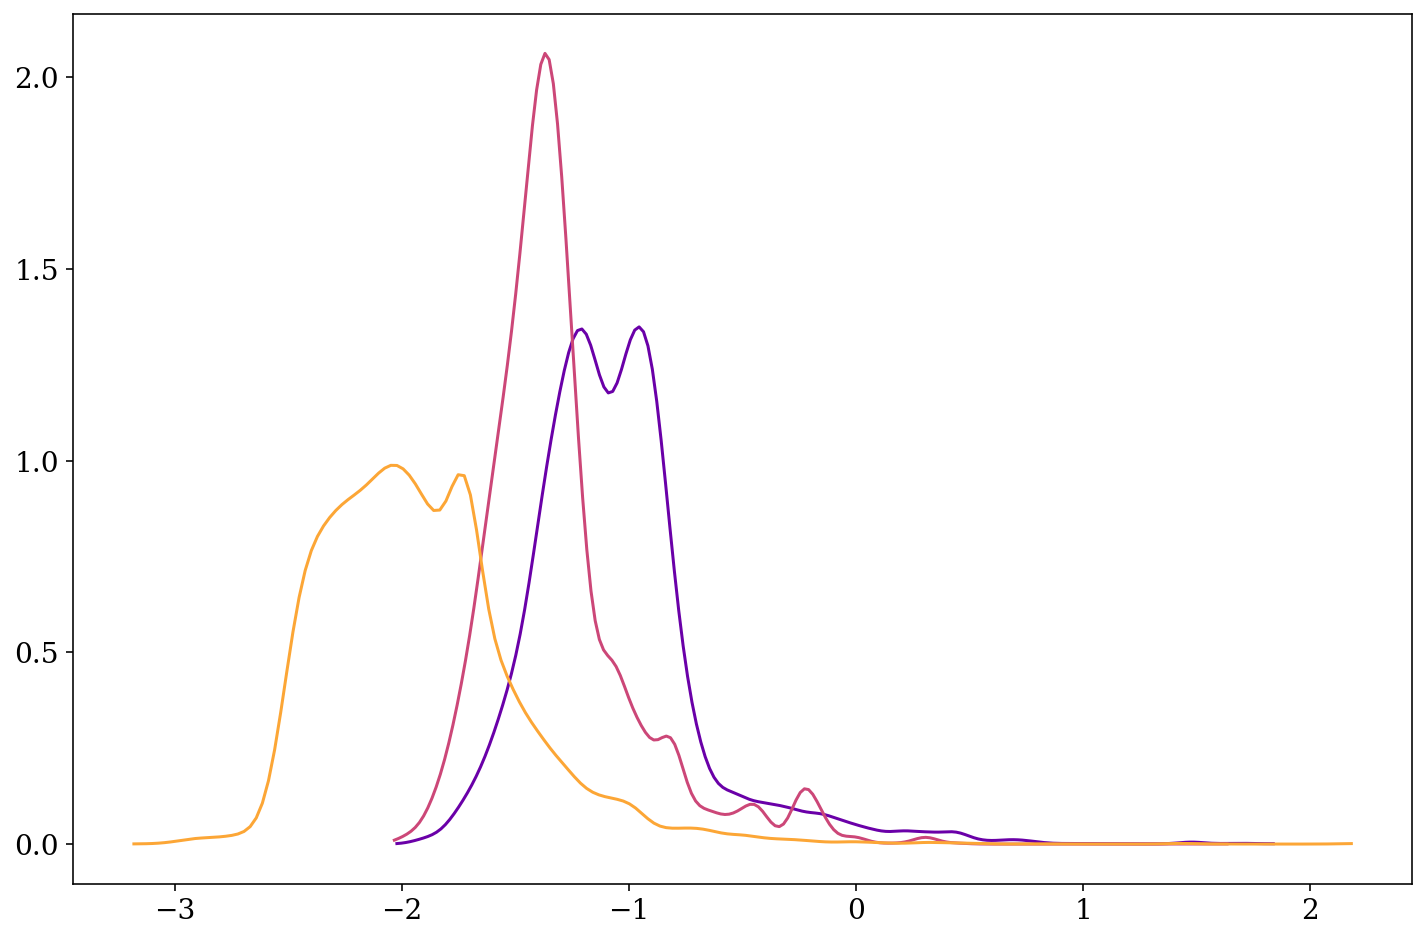

In [66]:
for dco_type in dco_types:

    with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, "wolf_rayet_multiplier_0_1"), "r") as f:
        data = f["simulation"][...].squeeze()

    plt.plot(*boots.kde(np.log10(data["a_DCO"]), weights=data["weight"]), color=dco_colours[dco_type])
    
# plt.plot([1e-2, 1e2], [1e-2, 1e2])
# plt.colorbar(scatter)

# plt.xscale("log")
# plt.yscale("log")
# plt.xlim(1e-4, 1)

plt.show()